* [I. Import Data and Data Split](#I)
* [II. XGBoost Model with 3D Feature Set](#II)
    * [2.1 Number of neighboring atoms: 3](#2.1)
    * [2.2 Number of neighboring atoms: 5](#2.2)
    * [2.3 Number of neighboring atoms: 7](#2.3)
    * [2.4 Number of neighboring atoms: 10](#2.4)
    * [2.5 Compare Model Performance Using the Validation Dataset](#2.5)
    * [2.6 Feature Importance Analysis](#2.6)
* [III. XGBoost Model with 2D Feature Set](#III)
    * [3.1 Number of spheres: 2](#3.1)
    * [3.2 Number of spheres: 3](#3.2)
    * [3.3 Number of spheres: 4](#3.3)
    * [3.4 Number of spheres: 5](#3.4)
    * [3.5 Compare Model Performance Using the Validation Dataset ](#3.5)
    * [3.6 Feature Importance Analysis](#3.6)
* [IV. Evaluate Model Performance Using the Test Dataset](#IV)

In [22]:
# https://numpy.org/doc/stable/release.html
import os
import sys
import numpy as np
import pandas as pd
import pickle

# plot
import matplotlib.pyplot as plt

%matplotlib inline
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import shap
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

RANDOM_STATE = 1
src_path = os.path.join("..")
if src_path not in sys.path:
    sys.path.append(src_path)

src_path = os.path.join("..", "src")
if src_path not in sys.path:
    sys.path.append(src_path)

src_path = os.path.join("..", "external", "HOSE_code_generator")
if src_path not in sys.path:
    sys.path.append(src_path)

from src import (
    common,
    atomic_features_2D,
    atomic_features_3D,
)  # Some common methods I defined

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 100)

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# I. Import Data and Data Split <a class="anchor" id="I"></a>

In [20]:
#
# Get the train, validation, and test datasets
#
data_path = os.path.join("..", "dataset", "Processed_PFAS_19F_NMR_spectra_data.csv")
All_fluorinated_compounds = pd.read_csv(data_path)
train_dataset, test_fluorinated_compounds = common.split_datasets(All_fluorinated_compounds, RANDOM_STATE=RANDOM_STATE, verbose = True)

Number of fluorinated compounds in the train and test datasets are 549 and 98 respectively.
Ratio of PFAS in the train and test datasets are 0.61 and 1.00 respectively.


In [4]:
train_dataset.head(3)

,Group,IsPFAS(haveCF2),Compound name,Code,Solvent_used_for_NMR,SMILES,Internal Standard,FluorineInConjSystem,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70
0,NaN,False,tert-butyl (E)-2-fluorodec-2-enoate,From_Review_182,CDCl3,CCCCCCC/C=C(/F)C(=O)OC(C)(C)C,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-121.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,True,difluoromethyl trifluoromethanesulfonate,From_Review_230,CDCl3,O=S(=O)(OC(F)F)C(F)(F)F,NaN,0.0,NaN,NaN,NaN,NaN,NaN,-83.0,-83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,False,2-fluorocyclopentan-1-one,From_Review_80,CDCl3,O=C1CCCC1F,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-194.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# II. XGBoost Model with 3D Feature Set <a class="anchor" id="II"></a>
**Use Atomic Features from Spatially Neighboring Atoms**

## 2.1 Number of neighbor atoms: n <a class="anchor" id="2.1"></a>
**Step 1. Combine atomic features with fluorinated compounds information**

In [7]:
# Combine NMR shift values of F atoms with its features
n = 5

# Split the train dataset into train and validation datasets
train_fluorinated_compounds, vali_fluorinated_compounds = common.split_datasets(train_dataset, RANDOM_STATE=RANDOM_STATE, verbose = True, set_name = 'validation')

train_fluorinated_compounds_w_Desc = atomic_features_3D.Combine_descriptors(
    train_fluorinated_compounds, num_neighbor=n, with_additional_info=True
)
print(
    f"Shape of the train_fluorinated_compounds_w_Desc: {train_fluorinated_compounds_w_Desc.shape}"
)

train_fluorinated_compounds_w_Desc.rename_axis(
    "atomCode_fluorinated_compoundsCode", inplace=True
)
train_fluorinated_compounds_w_Desc = train_fluorinated_compounds_w_Desc.apply(
    pd.to_numeric, errors="ignore"
)
# # Save to file
# file_path = os.path.join(
#     "..", "dataset", "Output_Train_neiber3_w all CDK descriptors_440.csv"
# )
# train_fluorinated_compounds_w_Desc.to_csv(file_path, encoding="UTF-8")

train_fluorinated_compounds_w_Desc.head(3)

Number of fluorinated compounds in the train and validation datasets are 466 and 83 respectively.
Ratio of PFAS in the train and validation datasets are 0.54 and 1.00 respectively.
Shape of the train_fluorinated_compounds_w_Desc: (2357, 122)


,NMR_Peaks,SMILES_self,AtomDegreeDescriptor-aNeg_self,AtomHybridizationDescriptor-aHyb_self,AtomHybridizationVSEPRDescriptor-hybr_self,AtomValenceDescriptor-val_self,BondsToAtomDescriptor-bondsToAtom_self,CovalentRadiusDescriptor-covalentRadius_self,DistanceToAtomDescriptor-distanceToAtom_self,EffectiveAtomPolarizabilityDescriptor-effAtomPol_self,IPAtomicHOSEDescriptor-ipAtomicHOSE_self,InductiveAtomicHardnessDescriptor-indAtomHardnesss_self,InductiveAtomicSoftnessDescriptor-indAtomSoftness_self,PartialPiChargeDescriptor-pepe_self,PartialSigmaChargeDescriptor-partialSigmaCharge_self,PartialTChargeMMFF94Descriptor-partialTCMMFF94_self,PartialTChargePEOEDescriptor-pepeT_self,PeriodicTablePositionDescriptor-periodicTablePosition_self,PiElectronegativityDescriptor-elecPiA_self,level_0_neighbor1,index_neighbor1,SMILES_neighbor1,AtomDegreeDescriptor-aNeg_neighbor1,AtomHybridizationDescriptor-aHyb_neighbor1,AtomHybridizationVSEPRDescriptor-hybr_neighbor1,AtomValenceDescriptor-val_neighbor1,BondsToAtomDescriptor-bondsToAtom_neighbor1,CovalentRadiusDescriptor-covalentRadius_neighbor1,DistanceToAtomDescriptor-distanceToAtom_neighbor1,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor1,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor1,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor1,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor1,PartialPiChargeDescriptor-pepe_neighbor1,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor1,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor1,PartialTChargePEOEDescriptor-pepeT_neighbor1,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor1,PiElectronegativityDescriptor-elecPiA_neighbor1,level_0_neighbor2,index_neighbor2,SMILES_neighbor2,AtomDegreeDescriptor-aNeg_neighbor2,AtomHybridizationDescriptor-aHyb_neighbor2,AtomHybridizationVSEPRDescriptor-hybr_neighbor2,AtomValenceDescriptor-val_neighbor2,BondsToAtomDescriptor-bondsToAtom_neighbor2,CovalentRadiusDescriptor-covalentRadius_neighbor2,DistanceToAtomDescriptor-distanceToAtom_neighbor2,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor2,...,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor3,PartialPiChargeDescriptor-pepe_neighbor3,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor3,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor3,PartialTChargePEOEDescriptor-pepeT_neighbor3,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor3,PiElectronegativityDescriptor-elecPiA_neighbor3,level_0_neighbor4,index_neighbor4,SMILES_neighbor4,AtomDegreeDescriptor-aNeg_neighbor4,AtomHybridizationDescriptor-aHyb_neighbor4,AtomHybridizationVSEPRDescriptor-hybr_neighbor4,AtomValenceDescriptor-val_neighbor4,BondsToAtomDescriptor-bondsToAtom_neighbor4,CovalentRadiusDescriptor-covalentRadius_neighbor4,DistanceToAtomDescriptor-distanceToAtom_neighbor4,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor4,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor4,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor4,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor4,PartialPiChargeDescriptor-pepe_neighbor4,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor4,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor4,PartialTChargePEOEDescriptor-pepeT_neighbor4,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor4,PiElectronegativityDescriptor-elecPiA_neighbor4,level_0_neighbor5,index_neighbor5,SMILES_neighbor5,AtomDegreeDescriptor-aNeg_neighbor5,AtomHybridizationDescriptor-aHyb_neighbor5,AtomHybridizationVSEPRDescriptor-hybr_neighbor5,AtomValenceDescriptor-val_neighbor5,BondsToAtomDescriptor-bondsToAtom_neighbor5,CovalentRadiusDescriptor-covalentRadius_neighbor5,DistanceToAtomDescriptor-distanceToAtom_neighbor5,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor5,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor5,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor5,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor5,PartialPiChargeDescriptor-pepe_neighbor5,Par

**Step 2. Data preprocessing and analysis**
* Drop column contains constant value
* Drop column contains > 80% ratio missing value
* Show the number of non-numeric values in each column
* Drop categorical columns
* Drop rows with NaN values the 'NMR_Peaks' column

In [8]:
dataset = train_fluorinated_compounds_w_Desc.copy()

dataset = common.drop_constant_col(dataset)
print(
    f"Shape of the training dataset after dropping out columns with constant values: {dataset.shape}"
)

dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)
print(
    f"\nShape of the training dataset after dropping out columns with more than 80% values being NaN: {dataset_dropNaN.shape}\n"
)

print("------Non numeric values in the dataset-------")
print(common.count_non_numeric_values(dataset_dropNaN))

# Drop categorical columns
dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

# drop rows with NaN values in the 'NMR_Peaks' column
dataset_dropNaN = dataset_dropCat.dropna(subset=["NMR_Peaks"])
print("\n")
print(f"-----Shape of the dataset after drop rows with NaN NMR peak values------")
print(dataset_dropNaN.shape)

print("\n")
print("-----Number of NaN values in each Column:-----")
print(dataset_dropNaN.isna().sum().sort_values(ascending=False))

Shape of the training dataset after dropping out columns with constant values: (2357, 108)

Shape of the training dataset after dropping out columns with more than 80% values being NaN: (2357, 108)

------Non numeric values in the dataset-------
Columns with Non-Numeric Values:
SMILES_neighbor1        2357
SMILES_neighbor2        2357
SMILES_neighbor3        2356
SMILES_neighbor4        2352
SMILES_neighbor5        2327
SMILES                  2357
Compound name           2357
Solvent_used_for_NMR    2357
dtype: int64
None


-----Shape of the dataset after drop rows with NaN NMR peak values------
(2288, 100)


-----Number of NaN values in each Column:-----
PiElectronegativityDescriptor-elecPiA_neighbor5               30
EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor5    30
index_neighbor5                                               30
AtomDegreeDescriptor-aNeg_neighbor5                           30
AtomHybridizationDescriptor-aHyb_neighbor5                    30
          

In [9]:
dataset_dropNaN.loc[:, "NMR_Peaks"] = pd.to_numeric(dataset_dropNaN["NMR_Peaks"], errors="coerce")
corr = dataset_dropNaN.corr(numeric_only=True)["NMR_Peaks"].abs()
corr.sort_values(ascending=False, inplace=True)
print(f'Number of features: {len(corr)}')
print(f'Number of features with correlation > 0.1: {len(corr[corr > 0.1])}')
print(f'Number of features with correlation > 0.3: {len(corr[corr > 0.3])}')


Number of features: 100
Number of features with correlation > 0.1: 58
Number of features with correlation > 0.3: 23


In [10]:
feature_with_r_above_03 = corr[corr > 0].index.tolist()
# feature_with_r_above_03.remove("NMR_Peaks")
feature_with_r_above_03

['NMR_Peaks',
 'PartialSigmaChargeDescriptor-partialSigmaCharge_self',
 'PiElectronegativityDescriptor-elecPiA_self',
 'PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor1',
 'AtomValenceDescriptor-val_neighbor3',
 'PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor1',
 'AtomDegreeDescriptor-aNeg_neighbor1',
 'AtomDegreeDescriptor-aNeg_neighbor2',
 'AtomDegreeDescriptor-aNeg_neighbor3',
 'AtomValenceDescriptor-val_neighbor2',
 'PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor3',
 'PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor3',
 'PartialTChargePEOEDescriptor-pepeT_neighbor1',
 'PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor2',
 'PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor2',
 'EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor3',
 'PartialTChargePEOEDescriptor-pepeT_neighbor3',
 'AtomHybridizationVSEPRDescriptor-hybr_neighbor3',
 'AtomHybridizationDescriptor-aHyb_neighbor3',
 'AtomHybridizationDescriptor-aHyb_neighbor2',
 'Atom

In [17]:
# columns = dataset_dropNaN.columns.tolist()
columns = feature_with_r_above_03
# Save the column names to a file
file_path = os.path.join(
    "..", "artifacts", "models", "column_names_neighbor3_xgboost_23_columns_with_r_above_03.pkl"
)
with open(file_path, "wb") as f:
    pickle.dump(columns, f)

**Step 3. Model hyperparameters and model training**

In [13]:
# Only keep the features with correlation above 0.3
dataset = dataset_dropNaN[feature_with_r_above_03]

# Get X and y
y_train = dataset["NMR_Peaks"]
orig_features = ["NMR_Peaks"]
X_train = dataset.drop(orig_features, axis=1)
X_train = X_train.apply(pd.to_numeric)

# Set Hyperparameters of the XGBoost model
param_grid = {
    "max_depth": [2, 3, 4],  # deeper trees are more prone to overfitting.
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [50, 100, 150],  # Corresponds to the number of boosting rounds
    "subsample": [0.7, 0.8, 0.9, 1.0],
    "gamma": [0.1, 0.2, 0.4],
    "reg_alpha": [0.1, 1, 2, 5, 10],
    "reg_lambda": [0.1, 1, 2, 5, 10],
}

# Define a custom RMSE scoring function
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Use the custom RMSE function with make_scorer
scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": make_scorer(rmse),  # Custom RMSE scorer
    "r2": "r2",
}

xgb_reg = XGBRegressor()

# Initialize GridSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_grid,
    n_iter=100, # how many different combinations of hyperparameters will be randomly sampled and tested.
    cv=5,
    scoring=scoring,
    refit="mae",
    verbose=1,
    random_state=RANDOM_STATE,
)

# Fit the model
random_search.fit(X_train, y_train, verbose=True)

# Get the best parameters
best_params = random_search.best_params_
best_scores = random_search.cv_results_

print(f"Best parameters found: {best_params}")

# Print out scoring metrics for the best model
print(
    f'MAE Score: {np.mean(-best_scores["mean_test_mae"]):.2f} ± {np.std(-best_scores["mean_test_mae"]):.2f}'
)
print(f"Root Mean Squared Error (RMSE): {np.mean(best_scores['mean_test_rmse']):.2f}")
print(
    f'R^2 Score: {np.mean(best_scores["mean_test_r2"]):.2f} ± {np.std(best_scores["mean_test_r2"]):.2f}'
)

best_model = random_search.best_estimator_

# Save the model to a file
file_path = os.path.join("..", "artifacts", "models", "xgboost_model_neighbor3_23_columns.json")
best_model.save_model(file_path)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 2, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.4}
MAE Score: 7.53 ± 4.68
Root Mean Squared Error (RMSE): 11.30
R^2 Score: 0.87 ± 0.13


Performance of the best model on the training set:


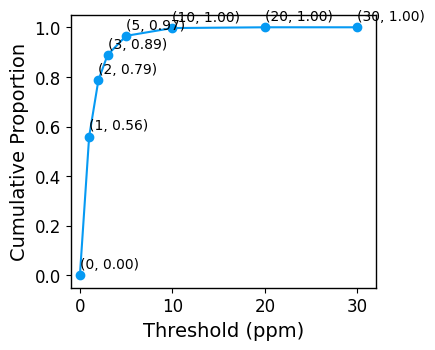

R2 = 1.00
RMSE = 2.03
MAE = 1.3514733841786017


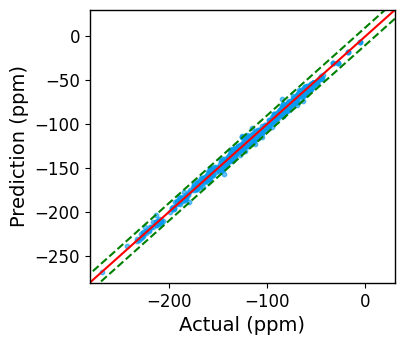

(1.3514733841786017, 2.0321488580527927, 0.9964898502461443)

In [15]:
print('Performance of the best model on the training set:')
results_table = common.get_results_table(best_model=best_model, X=X_train, y=y_train)
common.plot_prediction_performance(results_table)
common.show_results_scatter(results_table)

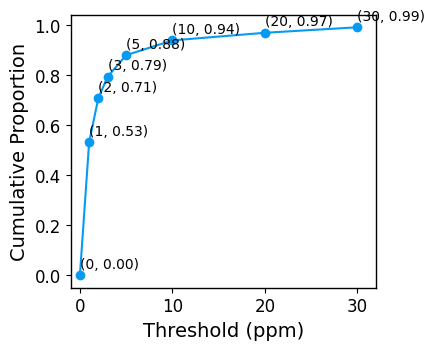

R2 = 0.95
RMSE = 5.92
MAE = 2.6471046058551684


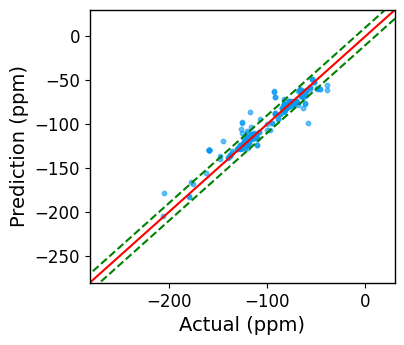

,actual,prediction,diff
9_From_Review_235,-120.00,-109.452423,10.547577
10_From_Review_235,-120.00,-107.106873,12.893127
6_other_9,-116.73,-115.270775,1.459225
7_other_9,-116.73,-114.582787,2.147213
9_other_9,-122.00,-121.132805,0.867195
...,...,...,...
34_COOH_31,-126.20,-126.545532,0.345532
35_COOH_31,-126.20,-126.545532,0.345532
37_COOH_31,-81.26,-81.390793,0.130793
38_COOH_31,-81.26,-81.390793,0.130793


In [18]:
# Test model performance on the validation dataset, 3D atomic features with 3 neighbor atoms
def test_model_performance_XGBoost_3D_23_cols(number_of_neighbors = 5, dataset):
    base_file_path = os.path.join("..", "artifacts", "models")

    results_table_vali = (
        atomic_features_3D.testModelPerformance_XGBoost_3DNeighborAtoms(
            best_model_file_path=os.path.join(
                base_file_path, f"xgboost_model_neighbor3_23_columns.json"
            ),
            columns_file_path=os.path.join(
                base_file_path, f"column_names_neighbor3_xgboost_23_columns_with_r_above_03.pkl"
            ),
            num_neighbor=number_of_neighbors,
            test_dataset=dataset,
        )
    )
    return results_table_vali

test_model_performance_XGBoost_3D_23_cols(number_of_neighbors = 5, dataset = vali_fluorinated_compounds)

## 2.2 Define modules

In [23]:
class Define_and_Train_XGboost_3D_Model():
    def __init__(self, num_neighbor, fluorinated_compounds, verbose = True):
        self.num_neighbor = num_neighbor
        fluorinated_compounds_w_Desc = self.step1_combine_atomic_feature_with_compounds(
            fluorinated_compounds, with_additional_info=True, verbose = verbose
        )
        self.processed_dataset = self.step2_data_preprocessing(fluorinated_compounds_w_Desc, verbose)
        return

    def step1_combine_atomic_feature_with_compounds(self, fluorinated_compounds, with_additional_info, verbose = True):
        # Combine NMR shift values of F atoms with its features
        fluorinated_compounds_w_Desc = atomic_features_3D.Combine_descriptors(
            fluorinated_compounds, num_neighbors=self.num_neighbor, with_additional_info=with_additional_info
        )
        fluorinated_compounds_w_Desc.rename_axis("atomCode_fluorinated_compoundsCode", inplace=True)
        fluorinated_compounds_w_Desc = fluorinated_compounds_w_Desc.apply(pd.to_numeric, errors="ignore") 
        
        # Save to file
        file_path = os.path.join("..", "artifacts", "temp", f"train_dataset_3D_neighbors{self.num_neighbor}_w all CDK descriptors_440.csv")
        fluorinated_compounds_w_Desc.to_csv(file_path, encoding="UTF-8")
        if verbose:
            print(f"Shape of the fluorinated_compounds_w_Desc: {fluorinated_compounds_w_Desc.shape}")
            print(f'Save the train dataset to {file_path} successfully!')
        return fluorinated_compounds_w_Desc
    
    def step2_data_preprocessing(self, dataset, verbose = True):
        # Data preprocessing
        dataset = common.drop_constant_col(dataset)
        dataset_dropNaN = common.drop_high_ratio_NaN_cols(dataset)
        dataset_dropCat = common.drop_categorical_columns(dataset_dropNaN)

        # drop rows with NaN values in the 'NMR_Peaks' column
        dataset_dropNaN = dataset_dropCat.dropna(subset=["NMR_Peaks"])

        # Save column names
        columns = dataset_dropNaN.columns.tolist()
        file_path = os.path.join(
            f"..", "artifacts", "models", f"column_names_neighbor{self.num_neighbor}_xgboost.pkl"
        )
        with open(file_path, "wb") as f:
            pickle.dump(columns, f)

        return dataset_dropNaN
    
    def step3_model_training(self, dataset, param_grid, random_seed):
        scoring = {
            "mae": "neg_mean_absolute_error",
            "rmse": make_scorer(
                mean_squared_error, squared=False, greater_is_better=False
            ),  # Root Mean Squared Error
            "r2": "r2",
        }

        y_train = dataset["NMR_Peaks"]
        X_train = dataset.drop(["NMR_Peaks"], axis=1)
        X_train = X_train.apply(pd.to_numeric)
        
        train_size = int(len(X_train) * 0.8)
        X_tr = X_train[:train_size]
        y_tr = y_train[:train_size]
        X_val = X_train[train_size:]
        y_val = y_train[train_size:]
   
        xgb_reg = XGBRegressor(early_stopping_rounds=20)
        if type(param_grid['n_estimators']) is list:
            # Initialize GridSearchCV
            random_search = RandomizedSearchCV(
                estimator=xgb_reg,
                param_distributions=param_grid,
                n_iter=30, # how many different combinations of hyperparameters will be randomly sampled and tested.
                cv=5,
                scoring=scoring,
                refit="mae",
                verbose=1,
                random_state=random_seed,
            )

            # Fit the model
            random_search.fit(X_tr, y_tr, eval_set = [(X_val, y_val)], verbose=False)

            # Get the best parameters
            best_params = random_search.best_params_
            best_model = random_search.best_estimator_

            print(f"Best parameters found: {best_params}")
        else:
            # If only one set of hyperparameters is provided, fit the model directly
            best_model = xgb_reg.set_params(**param_grid)
            best_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
            best_params = param_grid
            # Print out scoring metrics for the best model
    
        y_pred = best_model.predict(X_val)
        print(f'MAE Score: {mean_absolute_error(y_val, y_pred):.2f}')
        mse = mean_squared_error(y_val, y_pred)
        print(f'Root Mean Squared Error (RMSE): {np.sqrt(mse):.2f}')
        print(f'R^2 Score: {r2_score(y_val, y_pred):.2f}')

        # Save the model to a file
        file_path = os.path.join("..", "artifacts", "models", f"xgboost_model_neighbor{self.num_neighbor}.json")
        best_model.save_model(file_path)
        print(f'Save the model to {file_path} successfully!')
        return best_model, best_params


In [16]:
def testModelPerformance_XGBoost_3DNeighborAtoms(
    best_model_file_path, columns_file_path, num_neighbor, test_dataset, show_plot = True
):
    """
    Function
    ----------
    Applies the optimized model to the validation or test dataset, outputs the prediction results in a DataFrame,
    and visualizes the prediction performance using both a line plot and a scatter plot.
    Steps:
    a. Import necessary models, encoders, and column names used for model training.
    b. Process the validation dataset to ensure it matches the structure of the training dataset.
    c. Visualize the model fitting results.

    Parameters
    ----------
    best_model_file_path: Path to the .json file containing the optimized model.

    columns_file_path: Path to the .pkl file containing the column names of the dataset used for modeling.

    test_dataset: A DataFrame containing information about fluorinated compounds and their corresponding 19F NMR shift values.

    Output
    ----------
    results_table: A DataFrame containing the prediction results for the test_dataset.
    """
    best_model = XGBRegressor()
    best_model.load_model(best_model_file_path)

    with open(columns_file_path, "rb") as f:
        train_cols = pickle.load(f)

    # Step 1. Combine NMR shift values of F atoms with its features
    fluorinated_compounds_w_Desc = atomic_features_3D.Combine_descriptors(
        test_dataset, num_neighbors=num_neighbor
    )

    # Step 3. Only keep columns that were used in the dataset for modeling while delete other columns
    fluorinated_compounds_w_Desc = fluorinated_compounds_w_Desc[train_cols]

    # For validation purpose, drop rows with NaN values in the 'NMR_Peaks' column
    fluorinated_compounds_w_Desc = fluorinated_compounds_w_Desc.dropna(
        subset=["NMR_Peaks"]
    )

    # Get y values
    y = fluorinated_compounds_w_Desc["NMR_Peaks"]
    X = fluorinated_compounds_w_Desc.drop(["NMR_Peaks"], axis=1)

    # Ensure all values in the X are numerical values
    X = X.apply(pd.to_numeric)

    results_table = common.get_results_table(best_model=best_model, X=X, y=y)

    if show_plot:
        common.plot_prediction_performance(results_table, figure_title=None)
        common.show_results_scatter(results_table, figure_title=None)

    return results_table


In [17]:
# Test model performance on the validation dataset, 3D atomic features with 3 neighbor atoms
def test_model_performance_XGBoost_3D(num_neighbor, dataset, show_plot = False):
    base_file_path = os.path.join("..", "artifacts", "models")

    results_table = (
        testModelPerformance_XGBoost_3DNeighborAtoms(
            best_model_file_path=os.path.join(
                base_file_path, f"xgboost_model_neighbor{num_neighbor}.json"
            ),
            columns_file_path=os.path.join(
                base_file_path, f"column_names_neighbor{num_neighbor}_xgboost.pkl"
            ),
            num_neighbor=num_neighbor,
            test_dataset=dataset,
            show_plot = show_plot
        )
    )
    return results_table

In [18]:
def train_and_validate_xgboost3d_model(num_neighbor, train_dataset, param_grid, random_seeds=[1, 2, 3, 4, 5], show_plot = False, verbose = True):
    '''
    Build loops to train and validate the XGBoost 3D model with different random seeds and parameters.
    '''
    vali_results = {}
    train_results = {}
    vali_results_tables = pd.DataFrame()
    train_results_tables = pd.DataFrame()
    for random_seed in random_seeds:
        print(f"\n>>>>> Random seed: {random_seed} <<<<<")
        print(f'\nparam_grid: {param_grid}\n')
        train_fluorinated_compounds, vali_fluorinated_compounds = common.split_datasets(
            train_dataset, RANDOM_STATE=random_seed
        )
        # Data processing and get X, y
        xgboost = Define_and_Train_XGboost_3D_Model(num_neighbor=num_neighbor, fluorinated_compounds = train_fluorinated_compounds, verbose = verbose)

        # Grid search for the best alpha value
        best_model, best_params = xgboost.step3_model_training(xgboost.processed_dataset, param_grid, random_seed)

        # Apply the trained model on the validation dataset and return the results table
        train_results_table = test_model_performance_XGBoost_3D(num_neighbor=num_neighbor, dataset=train_fluorinated_compounds, show_plot = show_plot)
        vali_results_table = test_model_performance_XGBoost_3D(num_neighbor=num_neighbor, dataset=vali_fluorinated_compounds, show_plot = show_plot)

        vali_mae = mean_absolute_error(vali_results_table['actual'], vali_results_table['prediction'])
        vali_mse = mean_squared_error(vali_results_table['actual'], vali_results_table['prediction'])
        vali_rmse = np.sqrt(vali_mse)
        vali_r2 = r2_score(vali_results_table['actual'], vali_results_table['prediction'])
        vali_results[f'random_seed = {random_seed}, best_params = {best_params}'] = {'mae': vali_mae, 'rmse': vali_rmse, 'r2': vali_r2}

        train_mae = mean_absolute_error(train_results_table['actual'], train_results_table['prediction'])
        train_mse = mean_squared_error(train_results_table['actual'], train_results_table['prediction'])
        train_rmse = np.sqrt(train_mse)
        train_r2 = r2_score(train_results_table['actual'], train_results_table['prediction'])
        train_results[f'random_seed = {random_seed}, best_params = {best_params}'] = {'mae': train_mae, 'rmse': train_rmse, 'r2': train_r2}


        vali_results_tables = pd.concat([vali_results_tables, vali_results_table], axis=0)
        train_results_tables = pd.concat([train_results_tables, train_results_table], axis=0)
        # Clear memory after each iteration
        # Delete large objects explicitly
        try:
            del train_fluorinated_compounds, vali_fluorinated_compounds
            del vali_results_table, train_results_table
        except:
            pass

    vali_results_df = pd.DataFrame(vali_results).T
    train_results_df = pd.DataFrame(train_results).T

    print('--------Training results DataFrame--------')
    display(train_results_df)
    print('--------Validation results DataFrame--------')
    display(vali_results_df)
    return train_results_tables, train_results_df, vali_results_tables, vali_results_df, best_params

In [19]:
def show_model_perfromance_on_both_train_and_vali(train_results_tables, train_results_df, vali_results_tables, vali_results_df, model_info = ''):
    """
    Show the performance of the model on both training and validation datasets.
    This function prints the mean and standard deviation of the performance metrics (MAE, RMSE, R2) for both datasets,
    plots the prediction performance, and shows the results scatter plots.

    These information help to evaluate the model's performance and generalization ability, identify potential overfitting or underfitting issues.
    
    Args:
        train_results_tables: DataFrame with results of the model on training dataset.
        train_results_df: DataFrame with performance metrics on training dataset.
        vali_results_tables: DataFrame with results of the model on validation dataset.
        vali_results_df: DataFrame with performance metrics on validation dataset.
        model_info: String with information about the model.
    """
    print(f'\n>>>>> Model information: {model_info} <<<<<\n')
    print('Performance of the model on training dataset')
    print(f'mae: {train_results_df["mae"].mean():.2f} ± {train_results_df["mae"].std():.2f}')
    print(f'rmse: {train_results_df["rmse"].mean():.2f} ± {train_results_df["rmse"].std():.2f}')
    print(f'r2: {train_results_df["r2"].mean():.2f} ± {train_results_df["r2"].std():.2f}')

    print('\nPerformance of model on validation dataset')
    print(f'mae: {vali_results_df["mae"].mean():.2f} ± {vali_results_df["mae"].std():.2f}')
    print(f'rmse: {vali_results_df["rmse"].mean():.2f} ± {vali_results_df["rmse"].std():.2f}')
    print(f'r2: {vali_results_df["r2"].mean():.2f} ± {vali_results_df["r2"].std():.2f}')

    print('\n--------Training results plot--------')
    common.plot_prediction_performance(train_results_tables)
    print('\n--------Validation results plot--------')
    common.plot_prediction_performance(vali_results_tables)
    print('\n--------Training results scatter plot--------')
    common.show_results_scatter(train_results_tables)
    print('\n--------Validation results scatter plot--------')
    common.show_results_scatter(vali_results_tables)

## 2.3 Number of neighbor atoms: 3

In [73]:
param_grid = {
            "max_depth": [2, 3, 4],  # deeper trees are more prone to overfitting.
            "learning_rate": [0.01, 0.05],
            "n_estimators": [200, 300, 500],  # Corresponds to the number of boosting rounds
            "subsample": [0.5, 0.7, 0.9],
            "colsample_bytree": [0.5, 0.7, 0.9],
            "gamma": [0, 0.1, 0.2],
            "reg_alpha": [1, 5, 10],
            "reg_lambda": [1, 5, 10],
        }

_, _, _, _, best_params = train_and_validate_xgboost3d_model(num_neighbor = 3, train_dataset = train_dataset, param_grid = param_grid, random_seeds=[42], show_plot = False, verbose = False)


>>>>> Random seed: 42 <<<<<

param_grid: {'max_depth': [2, 3, 4], 'learning_rate': [0.01, 0.05], 'n_estimators': [200, 300, 500], 'subsample': [0.5, 0.7, 0.9], 'colsample_bytree': [0.5, 0.7, 0.9], 'gamma': [0, 0.1, 0.2], 'reg_alpha': [1, 5, 10], 'reg_lambda': [1, 5, 10]}

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}
MAE Score: 3.27
Root Mean Squared Error (RMSE): 6.12
R^2 Score: 0.97
Save the model to ../artifacts/models/xgboost_model_neighbor3.json successfully!
--------Training results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.147543,3.781091,0.987693


--------Validation results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.317843,4.273756,0.975214


In [74]:
random_seeds = [42, 30, 512, 76, 61]
train_results_tables, train_results_df, vali_results_tables, vali_results_df, _ = train_and_validate_xgboost3d_model(
                                                                                            num_neighbor = 3, 
                                                                                            train_dataset = train_dataset, 
                                                                                            param_grid = best_params, 
                                                                                            random_seeds=random_seeds, 
                                                                                            show_plot = False, 
                                                                                            verbose = False
                                                                                            )


>>>>> Random seed: 42 <<<<<

param_grid: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}

MAE Score: 3.27
Root Mean Squared Error (RMSE): 6.12
R^2 Score: 0.97
Save the model to ../artifacts/models/xgboost_model_neighbor3.json successfully!

>>>>> Random seed: 30 <<<<<

param_grid: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}

MAE Score: 3.62
Root Mean Squared Error (RMSE): 7.73
R^2 Score: 0.95
Save the model to ../artifacts/models/xgboost_model_neighbor3.json successfully!

>>>>> Random seed: 512 <<<<<

param_grid: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}

MAE Score: 3.05
Root Mean Squared Error (RMSE): 6.47
R^2 Score: 0.96
Save the model to ../artifacts/models/xgboost_model_ne

,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.147543,3.781091,0.987693
"random_seed = 30, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.670002,3.829086,0.987140
"random_seed = 512, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.676710,3.404970,0.990059
"random_seed = 76, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.421337,3.347475,0.990062
"random_seed = 61, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.875932,3.604439,0.989121


--------Validation results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.317843,4.273756,0.975214
"random_seed = 30, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.325841,4.365892,0.975823
"random_seed = 512, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.631122,5.159831,0.962426
"random_seed = 76, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.727790,4.952086,0.967678
"random_seed = 61, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.425367,4.990018,0.965178



>>>>> Model information: XGBoost 3D neighbor atoms model with 5 random seeds, num_neighbor = 3, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9} <<<<<

Performance of the model on training dataset
mae: 1.76 ± 0.27
rmse: 3.59 ± 0.22
r2: 0.99 ± 0.00

Performance of model on validation dataset
mae: 2.49 ± 0.19
rmse: 4.75 ± 0.40
r2: 0.97 ± 0.01

--------Training results plot--------


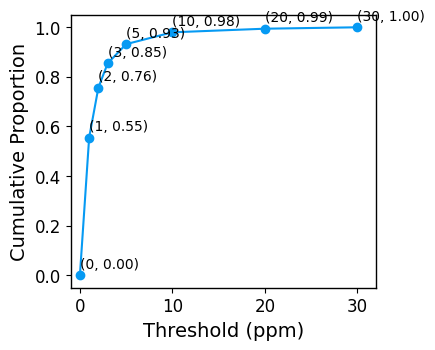


--------Validation results plot--------


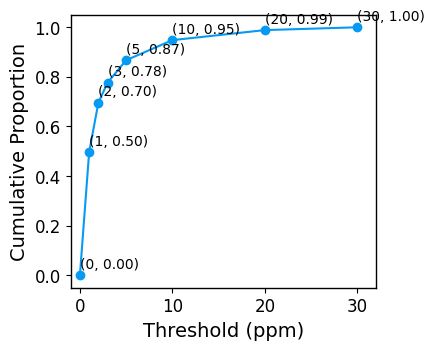


--------Training results scatter plot--------
R2 = 0.99
RMSE = 3.60
MAE = 1.7536306043982706


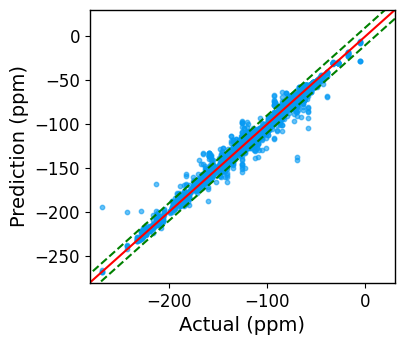


--------Validation results scatter plot--------
R2 = 0.97
RMSE = 4.76
MAE = 2.475652325693686


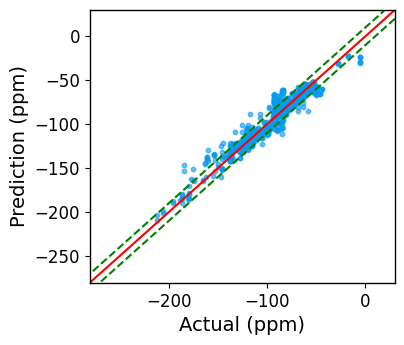

In [76]:
show_model_perfromance_on_both_train_and_vali(train_results_tables, train_results_df, vali_results_tables, vali_results_df, 
                                              model_info = f'XGBoost 3D neighbor atoms model with {len(train_results_df)} random seeds, num_neighbor = 3, best_params = {best_params}'
                                              )

## 2.3 Number of neighbor atoms: 4


>>>>> Random seed: 42 <<<<<

param_grid: {'max_depth': [2, 3, 4], 'learning_rate': [0.01, 0.05], 'n_estimators': [200, 300, 500], 'subsample': [0.5, 0.7, 0.9], 'colsample_bytree': [0.5, 0.7, 0.9], 'gamma': [0, 0.1, 0.2], 'reg_alpha': [1, 5, 10], 'reg_lambda': [1, 5, 10]}

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}
MAE Score: 3.32
Root Mean Squared Error (RMSE): 6.27
R^2 Score: 0.97
Save the model to ../artifacts/models/xgboost_model_neighbor4.json successfully!
--------Training results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.848025,3.440969,0.989808


--------Validation results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.163717,4.151171,0.976616



>>>>> Random seed: 42 <<<<<

param_grid: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}

MAE Score: 3.32
Root Mean Squared Error (RMSE): 6.27
R^2 Score: 0.97
Save the model to ../artifacts/models/xgboost_model_neighbor4.json successfully!

>>>>> Random seed: 30 <<<<<

param_grid: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}

MAE Score: 3.55
Root Mean Squared Error (RMSE): 7.35
R^2 Score: 0.95
Save the model to ../artifacts/models/xgboost_model_neighbor4.json successfully!

>>>>> Random seed: 512 <<<<<

param_grid: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}

MAE Score: 3.13
Root Mean Squared Error (RMSE): 6.16
R^2 Score: 0.97
Save the model to ../artifacts/models/xgboost_model_ne

,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.848025,3.440969,0.989808
"random_seed = 30, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.140329,4.146338,0.984921
"random_seed = 512, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.523328,3.127512,0.991613
"random_seed = 76, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.347574,3.379522,0.989871
"random_seed = 61, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.560765,3.298079,0.990892


--------Validation results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.163717,4.151171,0.976616
"random_seed = 30, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.552917,4.370276,0.975774
"random_seed = 512, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.613400,4.912948,0.965935
"random_seed = 76, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.746889,4.948866,0.967720
"random_seed = 61, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.214006,4.618378,0.970172



>>>>> Model information: XGBoost 3D neighbor atoms model with 5 random seeds, num_neighbor = 4, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9} <<<<<

Performance of the model on training dataset
mae: 1.68 ± 0.31
rmse: 3.48 ± 0.39
r2: 0.99 ± 0.00

Performance of model on validation dataset
mae: 2.46 ± 0.26
rmse: 4.60 ± 0.34
r2: 0.97 ± 0.00

--------Training results plot--------


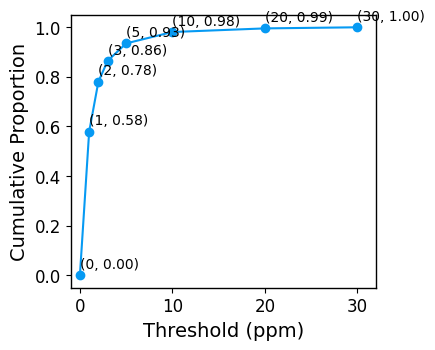


--------Validation results plot--------


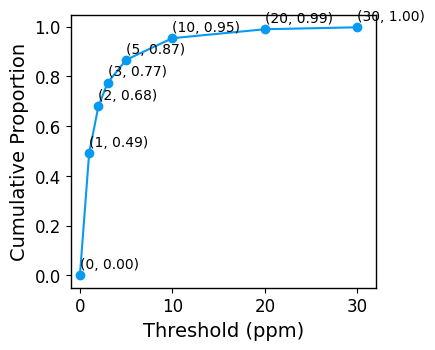


--------Training results scatter plot--------
R2 = 0.99
RMSE = 3.50
MAE = 1.6822856833194963


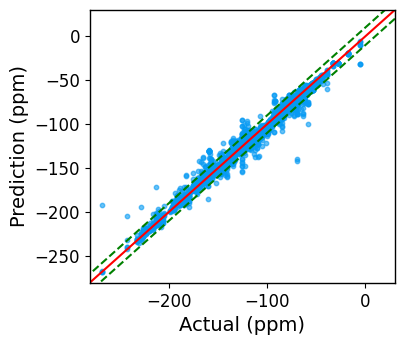


--------Validation results scatter plot--------
R2 = 0.97
RMSE = 4.60
MAE = 2.439598913937271


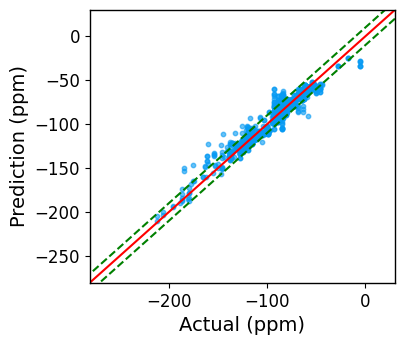

In [77]:
num_neighbor = 4
# Use random seed 42 to find the best hyperparameters
_, _, _, _, best_params = train_and_validate_xgboost3d_model(num_neighbor = num_neighbor, train_dataset = train_dataset, param_grid = param_grid, random_seeds=[42], show_plot = False, verbose = False)

# Use the best hyperparameters to train and validate the model with multiple random seeds for seperating train and validation dataset
random_seeds = [42, 30, 512, 76, 61]
train_results_tables, train_results_df, vali_results_tables, vali_results_df, _ = train_and_validate_xgboost3d_model(
                                                                                            num_neighbor = num_neighbor, 
                                                                                            train_dataset = train_dataset, 
                                                                                            param_grid = best_params, 
                                                                                            random_seeds=random_seeds, 
                                                                                            show_plot = False, 
                                                                                            verbose = False
                                                                                            )

# Show the performance of the model on both training and validation datasets with the best hyperparameters and 5 random seeds
show_model_perfromance_on_both_train_and_vali(train_results_tables, train_results_df, vali_results_tables, vali_results_df, 
                                              model_info = f'XGBoost 3D neighbor atoms model with {len(train_results_df)} random seeds, num_neighbor = {num_neighbor}, best_params = {best_params}'
                                              )


## 2.4 Number of neighbor atoms: 5 <a class="anchor" id="2.4"></a>


>>>>> Random seed: 42 <<<<<

param_grid: {'max_depth': [2, 3, 4], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [50, 100, 150], 'subsample': [0.7, 0.8, 0.9, 1.0], 'gamma': [0.1, 0.2, 0.4], 'reg_alpha': [0.1, 1, 2, 5, 10], 'reg_lambda': [0.1, 1, 2, 5, 10]}

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}
MAE Score: 3.18
Root Mean Squared Error (RMSE): 5.88
R^2 Score: 0.97
Save the model to ../artifacts/models/xgboost_model_neighbor5.json successfully!
--------Training results DataFrame--------


,mae,rmse,r2
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",1.976654,3.561286,0.989082


--------Validation results DataFrame--------


,mae,rmse,r2
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.20646,4.35132,0.974306



>>>>> Random seed: 42 <<<<<

param_grid: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}

MAE Score: 3.18
Root Mean Squared Error (RMSE): 5.88
R^2 Score: 0.97
Save the model to ../artifacts/models/xgboost_model_neighbor5.json successfully!

>>>>> Random seed: 30 <<<<<

param_grid: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}

MAE Score: 3.36
Root Mean Squared Error (RMSE): 6.97
R^2 Score: 0.96
Save the model to ../artifacts/models/xgboost_model_neighbor5.json successfully!

>>>>> Random seed: 512 <<<<<

param_grid: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}

MAE Score: 3.17
Root Mean Squared Error (RMSE): 6.34
R^2 Score: 0.96
Save the model to ../artifacts/models/xgboost_model_neighbor5.json successfully!

>>>>> Random seed: 76 <<<<<

param_grid: 

,mae,rmse,r2
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",1.976654,3.561286,0.989082
"random_seed = 30, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",1.619689,3.541233,0.989001
"random_seed = 512, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",1.667006,3.363132,0.990302
"random_seed = 76, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",1.680633,3.679738,0.987991
"random_seed = 61, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",1.784161,3.582020,0.989256


--------Validation results DataFrame--------


,mae,rmse,r2
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.206460,4.351320,0.974306
"random_seed = 30, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.430029,4.626354,0.972852
"random_seed = 512, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.555790,4.616314,0.969925
"random_seed = 76, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.836192,5.154168,0.964986
"random_seed = 61, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.153509,4.276413,0.974426



>>>>> Model information: XGBoost 3D neighbor atoms model with 5 random seeds, num_neighbor = 5, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2} <<<<<

Performance of the model on training dataset
mae: 1.75 ± 0.14
rmse: 3.55 ± 0.11
r2: 0.99 ± 0.00

Performance of model on validation dataset
mae: 2.44 ± 0.28
rmse: 4.60 ± 0.34
r2: 0.97 ± 0.00

--------Training results plot--------


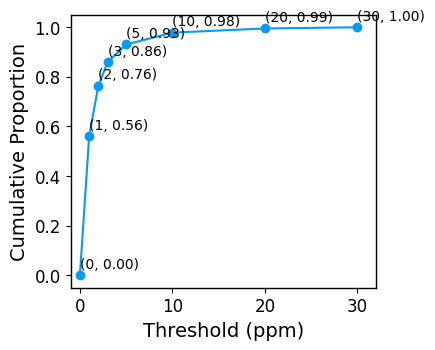


--------Validation results plot--------


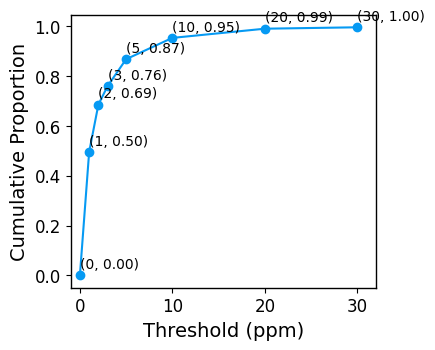


--------Training results scatter plot--------
R2 = 0.99
RMSE = 3.55
MAE = 1.7439384226024164


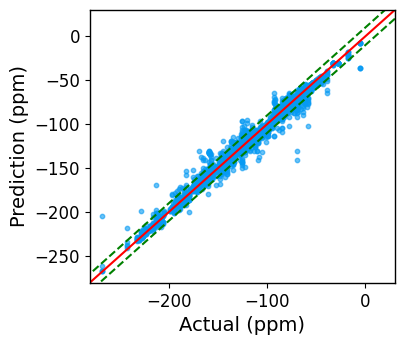


--------Validation results scatter plot--------
R2 = 0.97
RMSE = 4.59
MAE = 2.4151240074853484


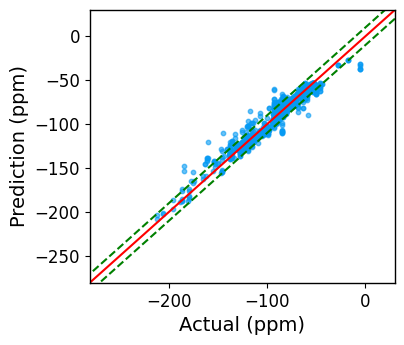

In [30]:
num_neighbor = 5
# Use random seed 42 to find the best hyperparameters
_, _, _, _, best_params = train_and_validate_xgboost3d_model(num_neighbor = num_neighbor, train_dataset = train_dataset, param_grid = param_grid, random_seeds=[42], show_plot = False, verbose = False)

# Use the best hyperparameters to train and validate the model with multiple random seeds for seperating train and validation dataset
random_seeds = [42, 30, 512, 76, 61]
train_results_tables_n5, train_results_df, vali_results_tables_n5, vali_results_df, _ = train_and_validate_xgboost3d_model(
                                                                                            num_neighbor = num_neighbor, 
                                                                                            train_dataset = train_dataset, 
                                                                                            param_grid = best_params, 
                                                                                            random_seeds=random_seeds, 
                                                                                            show_plot = False, 
                                                                                            verbose = False
                                                                                            )

# Show the performance of the model on both training and validation datasets with the best hyperparameters and 5 random seeds
show_model_perfromance_on_both_train_and_vali(train_results_tables_n5, train_results_df, vali_results_tables_n5, vali_results_df, 
                                              model_info = f'XGBoost 3D neighbor atoms model with {len(train_results_df)} random seeds, num_neighbor = {num_neighbor}, best_params = {best_params}'
                                              )

# Save the best model performance results on the validation dataset and the training dataset into CSV files
train_results_tables_n5.to_csv(os.path.join("..", "artifacts", "results", "XGBoost 3D_n5_Results On Training Dataset with 5 Random Seeds.csv"), index=True)
vali_results_tables_n5.to_csv(os.path.join("..", "artifacts", "results", "XGBoost 3D_n5_Results On Validation Dataset with 5 Random Seeds.csv.csv"), index=True)

**Note:** When training with XGBoost, scaling of input features and filling NaN values are **not required**. Like other tree-based algorithms, XGBoost is not sensitive to the scale of the input features. Additionally, XGBoost does not require the removal of less relevant features, as it inherently performs feature selection during training by assigning lower importance to them.

GridSearchCV is evaluating 12 different combinations of hyperparameters, and for each of these combinations, it is performing 3-fold cross-validation. This results in a total of 36 training fits across your data. Each fit corresponds to training the model with one specific set of hyperparameters on a training set and validating it on a validation set.

> Feature Importance: to understand which features are most influentail in making predictions. XGBoost provides several ways to evaluate feature importance. The improvement in accuracy brought by a feature to the branches it is on. Gain is often considered the most relevant attribute to interpret feature importance.

Prediction Performance of the training dataset using XGBoost Model with atomic features from 5 nearest neighbor atoms in 3D space.

## 2.5 Number of neighbor atoms: 6 <a class="anchor" id="2.5"></a>


>>>>> Random seed: 42 <<<<<

param_grid: {'max_depth': [2, 3, 4], 'learning_rate': [0.01, 0.05], 'n_estimators': [200, 300, 500], 'subsample': [0.5, 0.7, 0.9], 'colsample_bytree': [0.5, 0.7, 0.9], 'gamma': [0, 0.1, 0.2], 'reg_alpha': [1, 5, 10], 'reg_lambda': [1, 5, 10]}

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}
MAE Score: 3.24
Root Mean Squared Error (RMSE): 6.20
R^2 Score: 0.97
Save the model to ../artifacts/models/xgboost_model_neighbor6.json successfully!
--------Training results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.647505,3.234902,0.990992


--------Validation results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.131648,3.976208,0.978545



>>>>> Random seed: 42 <<<<<

param_grid: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}

MAE Score: 3.24
Root Mean Squared Error (RMSE): 6.20
R^2 Score: 0.97
Save the model to ../artifacts/models/xgboost_model_neighbor6.json successfully!

>>>>> Random seed: 30 <<<<<

param_grid: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}

MAE Score: 3.48
Root Mean Squared Error (RMSE): 7.22
R^2 Score: 0.95
Save the model to ../artifacts/models/xgboost_model_neighbor6.json successfully!

>>>>> Random seed: 512 <<<<<

param_grid: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}

MAE Score: 3.18
Root Mean Squared Error (RMSE): 6.18
R^2 Score: 0.96
Save the model to ../artifacts/models/xgboost_model_ne

,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.647505,3.234902,0.990992
"random_seed = 30, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.732016,3.699231,0.987998
"random_seed = 512, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.545869,3.134734,0.991575
"random_seed = 76, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.332601,3.314742,0.990255
"random_seed = 61, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.494597,3.260370,0.991099


--------Validation results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.131648,3.976208,0.978545
"random_seed = 30, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.370264,4.174023,0.977901
"random_seed = 512, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.653516,4.838767,0.966956
"random_seed = 76, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.732053,4.899021,0.968367
"random_seed = 61, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.231577,4.343548,0.973616



>>>>> Model information: XGBoost 3D neighbor atoms model with 5 random seeds, num_neighbor = 6, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9} <<<<<

Performance of the model on training dataset
mae: 1.55 ± 0.15
rmse: 3.33 ± 0.22
r2: 0.99 ± 0.00

Performance of model on validation dataset
mae: 2.42 ± 0.26
rmse: 4.45 ± 0.41
r2: 0.97 ± 0.01

--------Training results plot--------


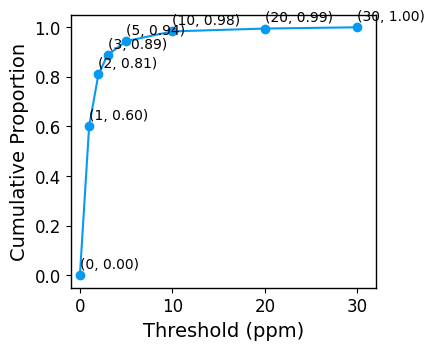


--------Validation results plot--------


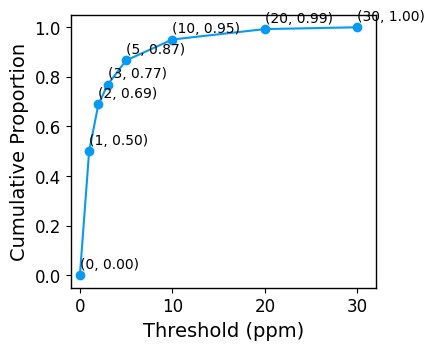


--------Training results scatter plot--------
R2 = 0.99
RMSE = 3.34
MAE = 1.549319434953536


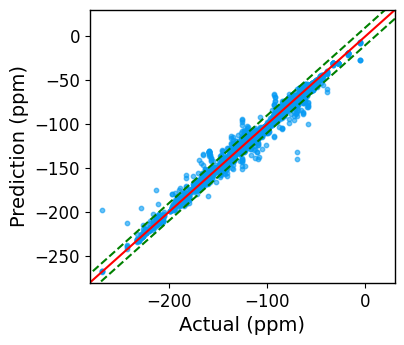


--------Validation results scatter plot--------
R2 = 0.97
RMSE = 4.44
MAE = 2.406243256371192


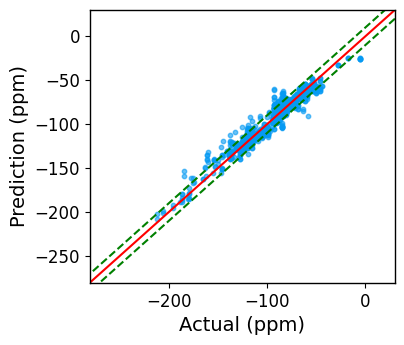

In [78]:
num_neighbor = 6

# Use random seed 42 to find the best hyperparameters
_, _, _, _, best_params = train_and_validate_xgboost3d_model(num_neighbor = num_neighbor, train_dataset = train_dataset, param_grid = param_grid, random_seeds=[42], show_plot = False, verbose = False)

# Use the best hyperparameters to train and validate the model with multiple random seeds for seperating train and validation dataset
random_seeds = [42, 30, 512, 76, 61]
train_results_tables, train_results_df, vali_results_tables, vali_results_df, _ = train_and_validate_xgboost3d_model(
                                                                                            num_neighbor = num_neighbor, 
                                                                                            train_dataset = train_dataset, 
                                                                                            param_grid = best_params, 
                                                                                            random_seeds=random_seeds, 
                                                                                            show_plot = False, 
                                                                                            verbose = False
                                                                                            )

# Show the performance of the model on both training and validation datasets with the best hyperparameters and 5 random seeds
show_model_perfromance_on_both_train_and_vali(train_results_tables, train_results_df, vali_results_tables, vali_results_df, 
                                              model_info = f'XGBoost 3D neighbor atoms model with {len(train_results_df)} random seeds, num_neighbor = {num_neighbor}, best_params = {best_params}'
                                              )

Prediction Performance of the training dataset using XGBoost Model with atomic features from 7 nearest neighbor atoms in 3D space.

## 2.6 Number of neighbor atoms: 7 <a class="anchor" id="2.6"></a>


>>>>> Random seed: 42 <<<<<

param_grid: {'max_depth': [2, 3, 4], 'learning_rate': [0.01, 0.05], 'n_estimators': [200, 300, 500], 'subsample': [0.5, 0.7, 0.9], 'colsample_bytree': [0.5, 0.7, 0.9], 'gamma': [0, 0.1, 0.2], 'reg_alpha': [1, 5, 10], 'reg_lambda': [1, 5, 10]}

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}
MAE Score: 3.33
Root Mean Squared Error (RMSE): 6.11
R^2 Score: 0.97
Save the model to ../artifacts/models/xgboost_model_neighbor7.json successfully!
--------Training results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.0733,3.647911,0.988545


--------Validation results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.306815,4.189064,0.976187



>>>>> Random seed: 42 <<<<<

param_grid: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}

MAE Score: 3.33
Root Mean Squared Error (RMSE): 6.11
R^2 Score: 0.97
Save the model to ../artifacts/models/xgboost_model_neighbor7.json successfully!

>>>>> Random seed: 30 <<<<<

param_grid: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}

MAE Score: 3.39
Root Mean Squared Error (RMSE): 7.05
R^2 Score: 0.96
Save the model to ../artifacts/models/xgboost_model_neighbor7.json successfully!

>>>>> Random seed: 512 <<<<<

param_grid: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}

MAE Score: 3.17
Root Mean Squared Error (RMSE): 6.30
R^2 Score: 0.96
Save the model to ../artifacts/models/xgboost_model_ne

,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.073300,3.647911,0.988545
"random_seed = 30, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.712149,3.621666,0.988496
"random_seed = 512, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.317047,3.019554,0.992182
"random_seed = 76, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.330945,3.412659,0.989671
"random_seed = 61, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.460038,3.255343,0.991126


--------Validation results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.306815,4.189064,0.976187
"random_seed = 30, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.475406,4.330282,0.976215
"random_seed = 512, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.554394,4.631132,0.969731
"random_seed = 76, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.732286,4.799999,0.969633
"random_seed = 61, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.259715,4.362820,0.973382



>>>>> Model information: XGBoost 3D neighbor atoms model with 5 random seeds, num_neighbor = 7, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9} <<<<<

Performance of the model on training dataset
mae: 1.58 ± 0.32
rmse: 3.39 ± 0.26
r2: 0.99 ± 0.00

Performance of model on validation dataset
mae: 2.47 ± 0.19
rmse: 4.46 ± 0.25
r2: 0.97 ± 0.00

--------Training results plot--------


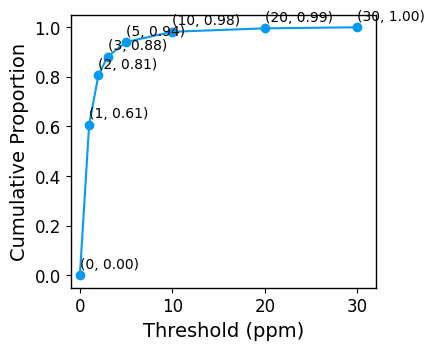


--------Validation results plot--------


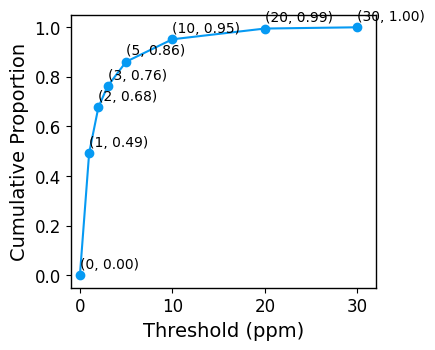


--------Training results scatter plot--------
R2 = 0.99
RMSE = 3.40
MAE = 1.5761451056348534


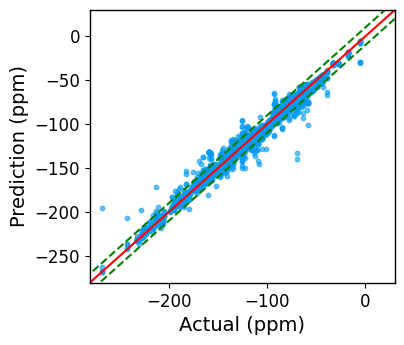


--------Validation results scatter plot--------
R2 = 0.97
RMSE = 4.45
MAE = 2.4508746293014663


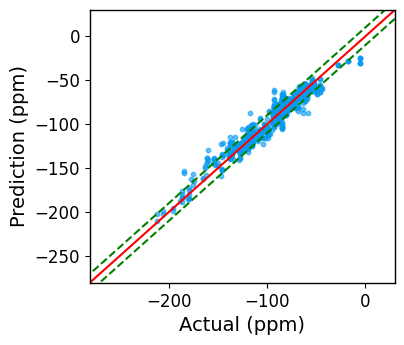

In [79]:
num_neighbor = 7

# Use random seed 42 to find the best hyperparameters
_, _, _, _, best_params = train_and_validate_xgboost3d_model(num_neighbor = num_neighbor, train_dataset = train_dataset, param_grid = param_grid, random_seeds=[42], show_plot = False, verbose = False)

# Use the best hyperparameters to train and validate the model with multiple random seeds for seperating train and validation dataset
random_seeds = [42, 30, 512, 76, 61]
train_results_tables, train_results_df, vali_results_tables, vali_results_df, _ = train_and_validate_xgboost3d_model(
                                                                                            num_neighbor = num_neighbor, 
                                                                                            train_dataset = train_dataset, 
                                                                                            param_grid = best_params, 
                                                                                            random_seeds=random_seeds, 
                                                                                            show_plot = False, 
                                                                                            verbose = False
                                                                                            )

# Show the performance of the model on both training and validation datasets with the best hyperparameters and 5 random seeds
show_model_perfromance_on_both_train_and_vali(train_results_tables, train_results_df, vali_results_tables, vali_results_df, 
                                              model_info = f'XGBoost 3D neighbor atoms model with {len(train_results_df)} random seeds, num_neighbor = {num_neighbor}, best_params = {best_params}'
                                              )

## 2.7 Number of neighbor atoms: 10 <a class="anchor" id="2.7"></a>


>>>>> Random seed: 42 <<<<<

param_grid: {'max_depth': [2, 3, 4], 'learning_rate': [0.01, 0.05], 'n_estimators': [200, 300, 500], 'subsample': [0.5, 0.7, 0.9], 'colsample_bytree': [0.5, 0.7, 0.9], 'gamma': [0, 0.1, 0.2], 'reg_alpha': [1, 5, 10], 'reg_lambda': [1, 5, 10]}

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}
MAE Score: 3.23
Root Mean Squared Error (RMSE): 6.05
R^2 Score: 0.97
Save the model to ../artifacts/models/xgboost_model_neighbor10.json successfully!
--------Training results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.40512,2.989273,0.992308


--------Validation results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.183601,4.128309,0.976873



>>>>> Random seed: 42 <<<<<

param_grid: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}

MAE Score: 3.23
Root Mean Squared Error (RMSE): 6.05
R^2 Score: 0.97
Save the model to ../artifacts/models/xgboost_model_neighbor10.json successfully!

>>>>> Random seed: 30 <<<<<

param_grid: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}

MAE Score: 3.57
Root Mean Squared Error (RMSE): 7.49
R^2 Score: 0.95
Save the model to ../artifacts/models/xgboost_model_neighbor10.json successfully!

>>>>> Random seed: 512 <<<<<

param_grid: {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}

MAE Score: 3.17
Root Mean Squared Error (RMSE): 6.21
R^2 Score: 0.96
Save the model to ../artifacts/models/xgboost_model_

,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.405120,2.989273,0.992308
"random_seed = 30, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.843583,3.876804,0.986818
"random_seed = 512, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.493493,3.101691,0.991751
"random_seed = 76, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.303867,3.363229,0.989968
"random_seed = 61, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",1.626065,3.402880,0.990304


--------Validation results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.183601,4.128309,0.976873
"random_seed = 30, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.468301,4.381231,0.975652
"random_seed = 512, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.568568,4.574254,0.970470
"random_seed = 76, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.764994,4.940901,0.967824
"random_seed = 61, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}",2.275209,4.369748,0.973297



>>>>> Model information: XGBoost 3D neighbor atoms model with 5 random seeds, num_neighbor = 10, best_params = {'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha': 5, 'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9} <<<<<

Performance of the model on training dataset
mae: 1.53 ± 0.21
rmse: 3.35 ± 0.34
r2: 0.99 ± 0.00

Performance of model on validation dataset
mae: 2.45 ± 0.23
rmse: 4.48 ± 0.30
r2: 0.97 ± 0.00

--------Training results plot--------


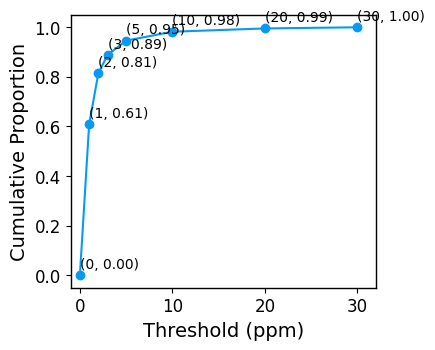


--------Validation results plot--------


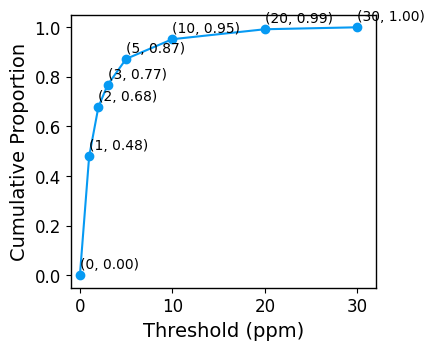


--------Training results scatter plot--------
R2 = 0.99
RMSE = 3.36
MAE = 1.5326204618984354


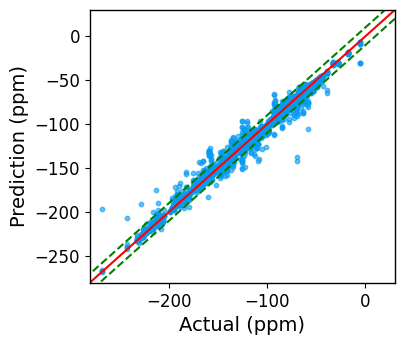


--------Validation results scatter plot--------
R2 = 0.97
RMSE = 4.47
MAE = 2.435664756575079


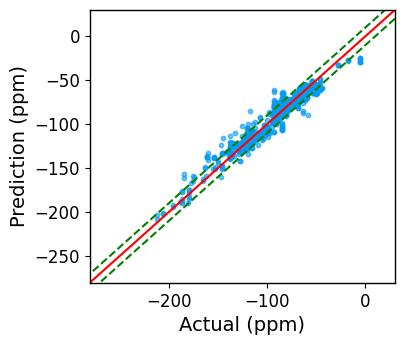

In [80]:
num_neighbor = 10

# Use random seed 42 to find the best hyperparameters
_, _, _, _, best_params = train_and_validate_xgboost3d_model(num_neighbor = num_neighbor, train_dataset = train_dataset, param_grid = param_grid, random_seeds=[42], show_plot = False, verbose = False)

# Use the best hyperparameters to train and validate the model with multiple random seeds for seperating train and validation dataset
random_seeds = [42, 30, 512, 76, 61]
train_results_tables, train_results_df, vali_results_tables, vali_results_df, _ = train_and_validate_xgboost3d_model(
                                                                                            num_neighbor = num_neighbor, 
                                                                                            train_dataset = train_dataset, 
                                                                                            param_grid = best_params, 
                                                                                            random_seeds=random_seeds, 
                                                                                            show_plot = False, 
                                                                                            verbose = False
                                                                                            )

# Show the performance of the model on both training and validation datasets with the best hyperparameters and 5 random seeds
show_model_perfromance_on_both_train_and_vali(train_results_tables, train_results_df, vali_results_tables, vali_results_df, 
                                              model_info = f'XGBoost 3D neighbor atoms model with {len(train_results_df)} random seeds, num_neighbor = {num_neighbor}, best_params = {best_params}'
                                              )

Prediction Performance of the training dataset using XGBoost Model with atomic features from 10 nearest neighbor atoms in 3D space.

## 2.8 Save optiaml model and its fitting results on the validation datasets

In [30]:
# # Save the optimal results to a CSV file
# file_path = os.path.join(
#     "..",
#     "artifacts",
#     "results",
#     "XGBoost_descriptors from 5 spatially neighboring atoms_validation dataset fitting results.csv",
# )
# results_table_vali.to_csv(file_path, encoding="UTF-8")

## 2.9 Feature Importance Analysis Use the Train Dataset <a class="anchor" id="2.9"></a>
**Top 10 Important Features Evaluated Based on Information Gain**

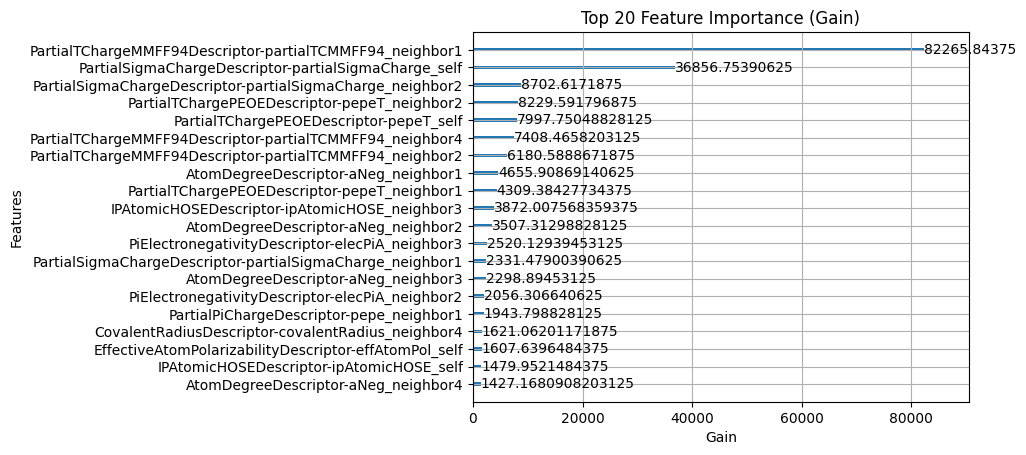

In [36]:
# best_model = XGBRegressor()
# file_path = os.path.join("..", "artifacts", "models", "xgboost_model_neighbor5.json")
# best_model.load_model(file_path)

# xgb.plot_importance(best_model, importance_type="gain", max_num_features=20)
# plt.title("Top 20 Feature Importance (Gain)")
# plt.xlabel("Gain")
# plt.ylabel("Features")
# plt.show()

# # PartialTChargeMMFF94Descriptors-partialTCMMFF94_neighbor1

After preprocessing, the left atom features used for modeling:  
**Target Fluorine Aatom**
* 1. BondsToAtomDescriptor-bondsToAtom_self
* 2. DistanceToAtomDescriptor-distanceToAtom_self
* 3. EffectiveAtomPolarizabilityDescriptor-effAtomPol_self
* 4. IPAtomicHOSEDescriptor-ipAtomicHOSE_self
* 5. InductiveAtomicHardnessDescriptor-indAtomHardnesss_self
* 6. InductiveAtomicSoftnessDescriptor-indAtomSoftness_self
* 7. PartialPiChargeDescriptor-pepe_self
* 8. PartialSigmaChargeDescriptor-partialSigmaCharge_self
* 9. PartialTChargeMMFF94Descriptor-partialTCMMFF94_self
* 10. PiElectronegativityDescriptor-elecPiA_self
* 11. ProtonAffinityHOSEDescriptor-protonAffiHOSE_self
* 12. RDFProtonDescriptor_G3R-g3r_2_self
------------------------
**1st Nearset Atom**
* AtomDegreeDescriptor-aNeg_neighbor1
* AtomHybridizationDescriptor-aHyb_neighbor1
* 1. BondsToAtomDescriptor-bondsToAtom_neighbor1
* 2. DistanceToAtomDescriptor-distanceToAtom_neighbor1
* 3. EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor1
* 5. InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor1
* 6. InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor1
* 7. PartialPiChargeDescriptor-pepe_neighbor1
* 8. PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor1
* 9. PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor1
* PeriodicTablePositionDescriptor-periodicTablePosition_neighbor1
* 10. PiElectronegativityDescriptor-elecPiA_neighbor1
* 12. RDFProtonDescriptor_G3R-g3r_2_neighbor1

**SHAP**

In [37]:
# file_path = os.path.join(
#     "..",
#     "artifacts",
#     "temp",
#     "train_dataset_3D_neighbors5_w all CDK descriptors_440.csv",
# )

# train_fluorinated_compounds_w_Desc = pd.read_csv(
#     file_path,
#     encoding="UTF-8",
#     index_col=0,
# )

# file_path = os.path.join(
#     "..", "artifacts", "models", "column_names_neighbor5_xgboost.pkl"
# )
# with open(file_path, "rb") as f:
#     train_cols = pickle.load(f)

# train_fluorinated_compounds_w_Desc = train_fluorinated_compounds_w_Desc[train_cols]
# train_fluorinated_compounds_w_Desc = train_fluorinated_compounds_w_Desc.dropna(
#     subset=["NMR_Peaks"]
# )

# columns_to_drop = ["NMR_Peaks"]
# X_train = train_fluorinated_compounds_w_Desc.drop(columns_to_drop, axis=1)

# train_fluorinated_compounds_w_Desc

,NMR_Peaks,BondsToAtomDescriptor-bondsToAtom_self,DistanceToAtomDescriptor-distanceToAtom_self,EffectiveAtomPolarizabilityDescriptor-effAtomPol_self,IPAtomicHOSEDescriptor-ipAtomicHOSE_self,InductiveAtomicHardnessDescriptor-indAtomHardnesss_self,InductiveAtomicSoftnessDescriptor-indAtomSoftness_self,PartialPiChargeDescriptor-pepe_self,PartialSigmaChargeDescriptor-partialSigmaCharge_self,PartialTChargeMMFF94Descriptor-partialTCMMFF94_self,PartialTChargePEOEDescriptor-pepeT_self,PiElectronegativityDescriptor-elecPiA_self,index_neighbor1,AtomDegreeDescriptor-aNeg_neighbor1,AtomHybridizationDescriptor-aHyb_neighbor1,AtomHybridizationVSEPRDescriptor-hybr_neighbor1,BondsToAtomDescriptor-bondsToAtom_neighbor1,DistanceToAtomDescriptor-distanceToAtom_neighbor1,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor1,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor1,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor1,PartialPiChargeDescriptor-pepe_neighbor1,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor1,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor1,PartialTChargePEOEDescriptor-pepeT_neighbor1,PiElectronegativityDescriptor-elecPiA_neighbor1,index_neighbor2,AtomDegreeDescriptor-aNeg_neighbor2,AtomHybridizationDescriptor-aHyb_neighbor2,AtomHybridizationVSEPRDescriptor-hybr_neighbor2,AtomValenceDescriptor-val_neighbor2,BondsToAtomDescriptor-bondsToAtom_neighbor2,CovalentRadiusDescriptor-covalentRadius_neighbor2,DistanceToAtomDescriptor-distanceToAtom_neighbor2,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor2,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor2,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor2,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor2,PartialPiChargeDescriptor-pepe_neighbor2,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor2,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor2,PartialTChargePEOEDescriptor-pepeT_neighbor2,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor2,PiElectronegativityDescriptor-elecPiA_neighbor2,index_neighbor3,AtomDegreeDescriptor-aNeg_neighbor3,AtomHybridizationDescriptor-aHyb_neighbor3,AtomHybridizationVSEPRDescriptor-hybr_neighbor3,AtomValenceDescriptor-val_neighbor3,BondsToAtomDescriptor-bondsToAtom_neighbor3,CovalentRadiusDescriptor-covalentRadius_neighbor3,DistanceToAtomDescriptor-distanceToAtom_neighbor3,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor3,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor3,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor3,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor3,PartialPiChargeDescriptor-pepe_neighbor3,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor3,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor3,PartialTChargePEOEDescriptor-pepeT_neighbor3,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor3,PiElectronegativityDescriptor-elecPiA_neighbor3,index_neighbor4,AtomDegreeDescriptor-aNeg_neighbor4,AtomHybridizationDescriptor-aHyb_neighbor4,AtomHybridizationVSEPRDescriptor-hybr_neighbor4,AtomValenceDescriptor-val_neighbor4,BondsToAtomDescriptor-bondsToAtom_neighbor4,CovalentRadiusDescriptor-covalentRadius_neighbor4,DistanceToAtomDescriptor-distanceToAtom_neighbor4,EffectiveAtomPolarizabilityDescriptor-effAtomPol_neighbor4,IPAtomicHOSEDescriptor-ipAtomicHOSE_neighbor4,InductiveAtomicHardnessDescriptor-indAtomHardnesss_neighbor4,InductiveAtomicSoftnessDescriptor-indAtomSoftness_neighbor4,PartialPiChargeDescriptor-pepe_neighbor4,PartialSigmaChargeDescriptor-partialSigmaCharge_neighbor4,PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor4,PartialTChargePEOEDescriptor-pepeT_neighbor4,PeriodicTablePositionDescriptor-periodicTablePosition_neighbor4,PiElectronegativityDescriptor-elecPiA_neighbor4,index_neighbor5,AtomDegreeDescriptor-aNeg_neighbor5,AtomHybridizationDescriptor-aHyb_neighbor5,AtomHybridizationVSEPRDescriptor-hybr_neighbor5,AtomValenceDescriptor-val_neighbor5,BondsToAtomDescriptor-bondsToAtom_neighbor5,

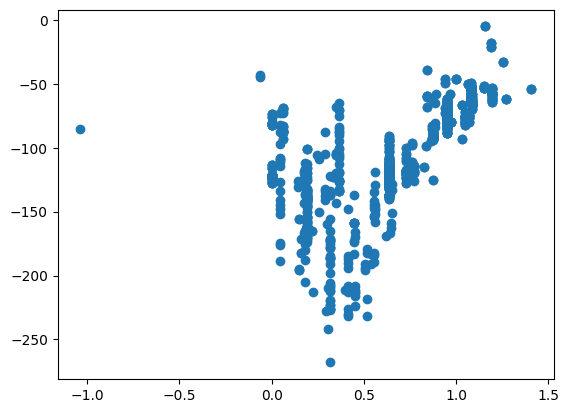

In [38]:
# feature_id = "PartialTChargeMMFF94Descriptor-partialTCMMFF94_neighbor1"  # Revise this value to see the relationship between NMR shifts and different features
# rel_shifts = train_fluorinated_compounds_w_Desc.loc[:, [feature_id, "NMR_Peaks"]]
# rel_shifts[feature_id].fillna(0, inplace=True)
# plt.plot(rel_shifts[feature_id], rel_shifts["NMR_Peaks"], "o")

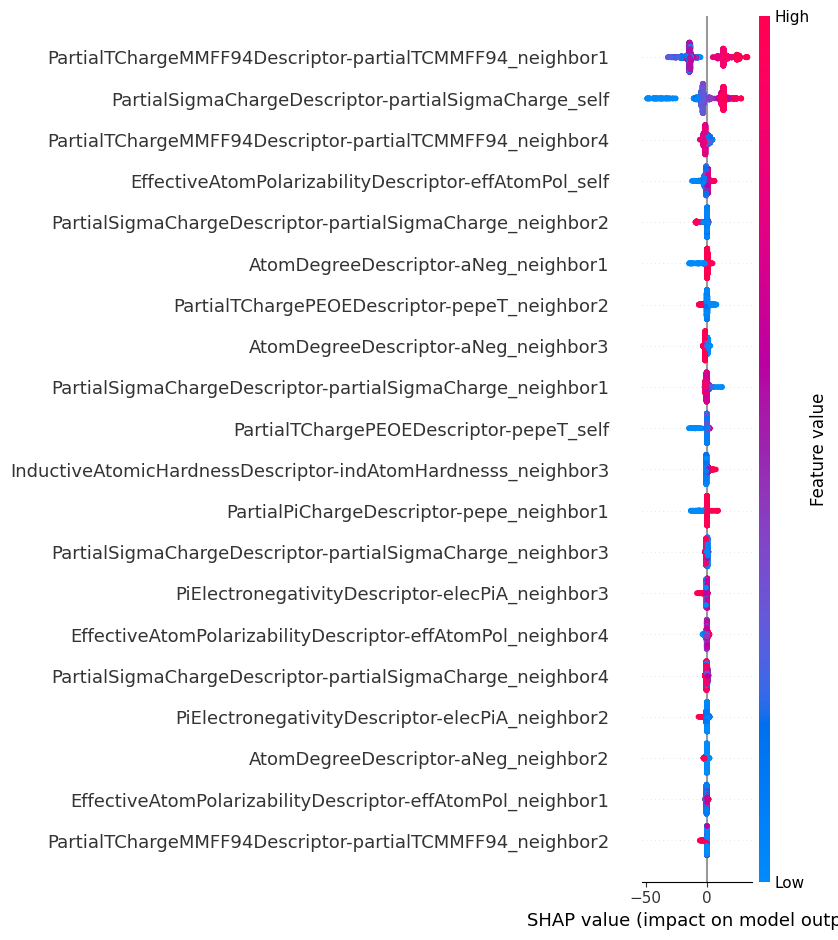

In [39]:
# # Create the SHAP explainer
# explainer = shap.TreeExplainer(best_model)
# shap_values = explainer.shap_values(X_train)

# # Plot the summary plot
# shap.summary_plot(shap_values, X_train)

This summary plot shows the distribution of SHAP values for each feature, indicating how each feature contributes positively or negatively to the predictions.

**Partial Dependence Plots (PDP)**

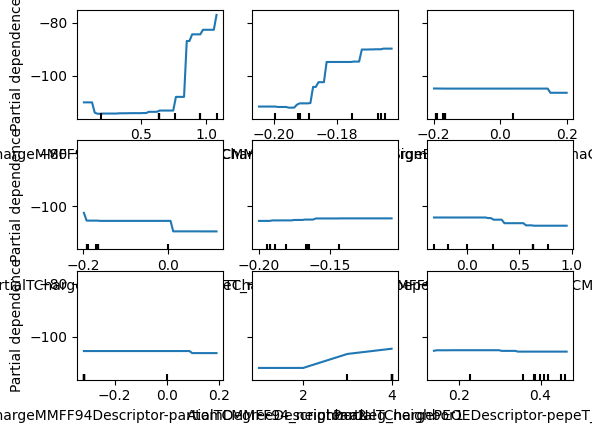

In [40]:
# importance = best_model.get_booster().get_score(importance_type="gain")
# importance_df = pd.DataFrame(importance.items(), columns=["Feature", "Gain"])

# # Sort by gain and get the top N features
# top_n = 9  # Change this to the number of features you want to plot
# top_importance_df = importance_df.sort_values(by="Gain", ascending=False).head(top_n)

# # Extract the feature names for the PDP
# top_features = top_importance_df["Feature"].tolist()

# # Plot Partial Dependence Plots for the top features
# disp = PartialDependenceDisplay.from_estimator(
#     best_model, X_train, features=top_features, grid_resolution=50
# )

# plt.show()

# III. XGBoost Model with 2D Feature Set<a class="anchor" id="III"></a>

## 3.2 Define class to train the model with 2D descriptors

In [25]:
class Define_and_Train_Model_2D_XGBoost():
    def __init__(self, num_spheres, fluorinated_compounds):
        self.num_spheres = num_spheres
        self.fluorinated_compounds = fluorinated_compounds
        self.processed_dataset = self.step1_get_features_and_data_preprocessing()
        return
    
    def step1_get_features_and_data_preprocessing(self):
        get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
        dataset = get_2d_descriptors.getDescriptorsFromDataset(
            self.fluorinated_compounds, self.num_spheres
        )

        dataset = dataset.apply(pd.to_numeric, errors="ignore") 
        # Data processing is simple as XGBoost model can handle NaN values
        dataset = dataset.dropna(subset=["NMR_Peaks"])

        # Data preprocessing
        print(f'Shape of dataset before preprocessing: {dataset.shape}')
        dataset = common.drop_constant_col(dataset)
        dataset = common.drop_high_ratio_NaN_cols(dataset)
        dataset = common.drop_categorical_columns(dataset)
        print(f'Shape of dataset after preprocessing: {dataset.shape}')

        # Save column names
        dataset.columns = dataset.columns.astype(str)
        columns = dataset.columns.tolist()
        file_path = os.path.join(
            f"..", "artifacts", "models", f"column_names_sphere{self.num_spheres}_xgboost.pkl"
        )
        with open(file_path, "wb") as f:
            pickle.dump(columns, f)
            
        return dataset

    def step2_train_model(self, dataset, param_grid, random_seed):
        y_train = dataset["NMR_Peaks"]
        X_train = dataset.drop(["NMR_Peaks"], axis=1)

        train_size = int(len(X_train) * 0.8)
        X_tr = X_train[:train_size]
        y_tr = y_train[:train_size]
        X_val = X_train[train_size:]
        y_val = y_train[train_size:]
   
        xgb_reg = XGBRegressor(early_stopping_rounds=20)
        scoring = {
            "mae": "neg_mean_absolute_error",
            "rmse": make_scorer(
                mean_squared_error, squared=False, greater_is_better=False
            ),
            "r2": "r2",
        }

        if type(param_grid['n_estimators']) is list:
            # Initialize GridSearchCV
            random_search = RandomizedSearchCV(
                estimator=xgb_reg,
                param_distributions=param_grid,
                n_iter=30, # how many different combinations of hyperparameters will be randomly sampled and tested.
                cv=5,
                scoring=scoring,
                refit="mae",
                verbose=1,
                random_state=random_seed,
            )

            # Fit the model
            random_search.fit(X_tr, y_tr, eval_set = [(X_val, y_val)],  # Use validation set for early stopping
                            verbose=False)

            # Get the best parameters
            best_params = random_search.best_params_
            print(f"Best parameters found: {best_params}")

            best_model = random_search.best_estimator_
        else:
            # If only one set of hyperparameters is provided, fit the model directly
            best_model = xgb_reg.set_params(**param_grid)
            best_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
            best_params = param_grid

        # Print out scoring metrics for the best model
        y_pred = best_model.predict(X_val)
        print(f'MAE Score: {mean_absolute_error(y_val, y_pred):.2f}')
        mse = mean_squared_error(y_val, y_pred)
        print(f'Root Mean Squared Error (RMSE): {np.sqrt(mse):.2f}')
        print(f'R^2 Score: {r2_score(y_val, y_pred):.2f}')

        # Save the model to a file
        file_path = os.path.join(
            "..", "artifacts", "models", f"xgboost_model_2d_descriptors_sphere{self.num_spheres}.json"
        )
        best_model.save_model(file_path)
        print(f'Save the model to {file_path} successfully!')
        return best_model, best_params

In [26]:
def test_2D_XGBoost_models(num_spheres, dataset, show_plot = False):
    file_path = os.path.join(
        "..", "artifacts", "models", f"xgboost_model_2d_descriptors_sphere{num_spheres}.json"
    )
    columns_path = os.path.join(
        "..", "artifacts", "models", f"column_names_sphere{num_spheres}_xgboost.pkl"
    )
    get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()

    results_table = get_2d_descriptors.testXGBoost2DModelPerformance(
        XGBoost_model_path = file_path,
        columns_path = columns_path,
        dataset=dataset,
        num_spheres=num_spheres,
        show_plot = show_plot
    )
    return results_table

In [27]:
def train_and_validate_xgboost2d_model(num_spheres, train_dataset, param_grid, random_seeds=[1, 2, 3, 4, 5], show_plot = False):
    '''
    Build loops to train and validate the XGBoost 3D model with different random seeds and parameters.
    '''
    vali_results = {}
    train_results = {}
    vali_results_tables = pd.DataFrame()
    train_results_tables = pd.DataFrame()
    for random_seed in random_seeds:
        print(f"\n>>>>> Random seed: {random_seed} <<<<<")
        print(f'\nparam_grid: {param_grid}\n')
        train_fluorinated_compounds, vali_fluorinated_compounds = common.split_datasets(
            train_dataset, RANDOM_STATE=random_seed
        )
        # Data processing and get X, y
        xgboost = Define_and_Train_Model_2D_XGBoost(num_spheres=num_spheres, fluorinated_compounds = train_fluorinated_compounds)

        # Grid search for the best alpha value
        best_model, best_params = xgboost.step2_train_model(xgboost.processed_dataset, param_grid, random_seed)

        # Apply the trained model on the validation dataset and return the results table
        train_results_table = test_2D_XGBoost_models(num_spheres=num_spheres, dataset=train_fluorinated_compounds, show_plot = show_plot)
        vali_results_table = test_2D_XGBoost_models(num_spheres=num_spheres, dataset=vali_fluorinated_compounds, show_plot = show_plot)

        vali_mae = mean_absolute_error(vali_results_table['actual'], vali_results_table['prediction'])
        vali_mse = mean_squared_error(vali_results_table['actual'], vali_results_table['prediction'])
        vali_rmse = np.sqrt(vali_mse)
        vali_r2 = r2_score(vali_results_table['actual'], vali_results_table['prediction'])
        vali_results[f'random_seed = {random_seed}, best_params = {best_params}'] = {'mae': vali_mae, 'rmse': vali_rmse, 'r2': vali_r2}

        train_mae = mean_absolute_error(train_results_table['actual'], train_results_table['prediction'])
        train_mse = mean_squared_error(train_results_table['actual'], train_results_table['prediction'])
        train_rmse = np.sqrt(train_mse)
        train_r2 = r2_score(train_results_table['actual'], train_results_table['prediction'])
        train_results[f'random_seed = {random_seed}, best_params = {best_params}'] = {'mae': train_mae, 'rmse': train_rmse, 'r2': train_r2}


        vali_results_tables = pd.concat([vali_results_tables, vali_results_table], axis=0)
        train_results_tables = pd.concat([train_results_tables, train_results_table], axis=0)
        # Clear memory after each iteration
        # Delete large objects explicitly
        try:
            del train_fluorinated_compounds, vali_fluorinated_compounds
            del vali_results_table, train_results_table
        except:
            pass

    vali_results_df = pd.DataFrame(vali_results).T
    train_results_df = pd.DataFrame(train_results).T
    print('--------Training results DataFrame--------')
    display(train_results_df)
    print('--------Validation results DataFrame--------')
    display(vali_results_df)
    return train_results_tables, train_results_df, vali_results_tables, vali_results_df, best_params

## 3.2 Number of spheres: 2


>>>>> Random seed: 42 <<<<<

param_grid: {'max_depth': [2, 3, 4], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [50, 100, 150], 'subsample': [0.7, 0.8, 0.9, 1.0], 'gamma': [0.1, 0.2, 0.4], 'reg_alpha': [0.1, 1, 2, 5, 10], 'reg_lambda': [0.1, 1, 2, 5, 10]}

Shape of dataset before preprocessing: (2215, 29)
Shape of dataset after preprocessing: (2215, 28)
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}
MAE Score: 4.81
Root Mean Squared Error (RMSE): 7.62
R^2 Score: 0.95
Save the model to ../artifacts/models/xgboost_model_2d_descriptors_sphere2.json successfully!
--------Training results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",4.106442,7.137789,0.956178


--------Validation results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",3.019825,5.272106,0.962282



>>>>> Random seed: 42 <<<<<

param_grid: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}

Shape of dataset before preprocessing: (2215, 29)
Shape of dataset after preprocessing: (2215, 28)
MAE Score: 4.81
Root Mean Squared Error (RMSE): 7.62
R^2 Score: 0.95
Save the model to ../artifacts/models/xgboost_model_2d_descriptors_sphere2.json successfully!

>>>>> Random seed: 30 <<<<<

param_grid: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}

Shape of dataset before preprocessing: (2257, 29)
Shape of dataset after preprocessing: (2257, 28)
MAE Score: 4.76
Root Mean Squared Error (RMSE): 8.43
R^2 Score: 0.94
Save the model to ../artifacts/models/xgboost_model_2d_descriptors_sphere2.json successfully!

>>>>> Random seed: 512 <<<<<

param_grid: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'lear

,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",4.106442,7.137789,0.956178
"random_seed = 30, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",4.070151,7.012484,0.956904
"random_seed = 512, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",3.938786,6.691230,0.961642
"random_seed = 76, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",4.120335,7.441936,0.950921
"random_seed = 61, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",4.064124,7.184361,0.956815


--------Validation results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",3.019825,5.272106,0.962282
"random_seed = 30, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",3.189103,5.297150,0.964408
"random_seed = 512, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",3.817986,7.057380,0.929708
"random_seed = 76, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",3.907805,6.399357,0.946025
"random_seed = 61, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.993701,5.520423,0.957382



>>>>> Model information: XGBoost 2D neighbor atoms model with 5 random seeds, num_spheres = 2, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2} <<<<<

Performance of the model on training dataset
mae: 4.06 ± 0.07
rmse: 7.09 ± 0.27
r2: 0.96 ± 0.00

Performance of model on validation dataset
mae: 3.39 ± 0.44
rmse: 5.91 ± 0.79
r2: 0.95 ± 0.01

--------Training results plot--------


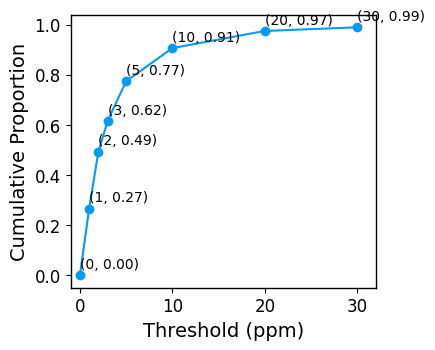


--------Validation results plot--------


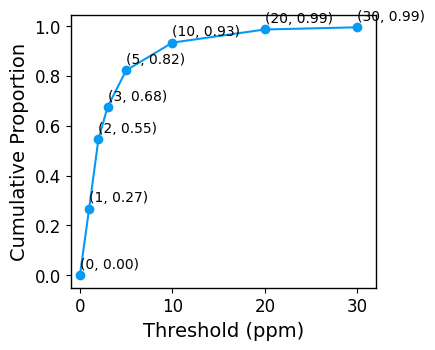


--------Training results scatter plot--------
R2 = 0.96
RMSE = 7.10
MAE = 4.060008484028823


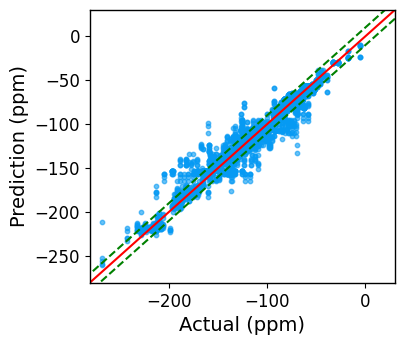


--------Validation results scatter plot--------
R2 = 0.95
RMSE = 5.91
MAE = 3.355349466316028


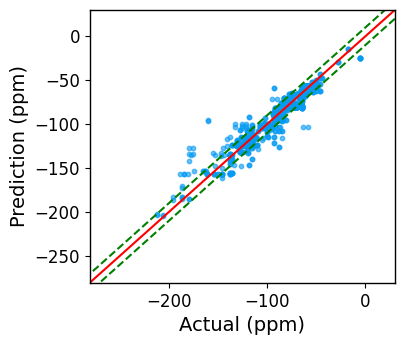

In [13]:
num_spheres = 2

# Use random seed 42 to find the best hyperparameters
_, _, _, _, best_params = train_and_validate_xgboost2d_model(num_spheres = num_spheres, train_dataset = train_dataset, param_grid = param_grid, random_seeds=[42], show_plot = False)

# Use the best hyperparameters to train and validate the model with multiple random seeds for seperating train and validation dataset
random_seeds = [42, 30, 512, 76, 61]
train_results_tables, train_results_df, vali_results_tables, vali_results_df, _ = train_and_validate_xgboost2d_model(
                                                                                            num_spheres = num_spheres, 
                                                                                            train_dataset = train_dataset, 
                                                                                            param_grid = best_params, 
                                                                                            random_seeds=random_seeds, 
                                                                                            show_plot = False, 
                                                                                            )

# Show the performance of the model on both training and validation datasets with the best hyperparameters and 5 random seeds
show_model_perfromance_on_both_train_and_vali(train_results_tables, train_results_df, vali_results_tables, vali_results_df, 
                                              model_info = f'XGBoost 2D neighbor atoms model with {len(train_results_df)} random seeds, num_spheres = {num_spheres}, best_params = {best_params}'
                                              )

## 3.3 Number of spheres: 3<a class="anchor" id="3.3"></a>


>>>>> Random seed: 42 <<<<<

param_grid: {'max_depth': [2, 3, 4], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [50, 100, 150], 'subsample': [0.7, 0.8, 0.9, 1.0], 'gamma': [0.1, 0.2, 0.4], 'reg_alpha': [0.1, 1, 2, 5, 10], 'reg_lambda': [0.1, 1, 2, 5, 10]}

Shape of dataset before preprocessing: (2215, 92)
Shape of dataset after preprocessing: (2215, 70)
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}
MAE Score: 3.22
Root Mean Squared Error (RMSE): 6.04
R^2 Score: 0.97
Save the model to ../artifacts/models/xgboost_model_2d_descriptors_sphere3.json successfully!
--------Training results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.599397,4.777421,0.980369


--------Validation results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.405029,5.059256,0.965266



>>>>> Random seed: 42 <<<<<

param_grid: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}

Shape of dataset before preprocessing: (2215, 92)
Shape of dataset after preprocessing: (2215, 70)
MAE Score: 3.22
Root Mean Squared Error (RMSE): 6.04
R^2 Score: 0.97
Save the model to ../artifacts/models/xgboost_model_2d_descriptors_sphere3.json successfully!

>>>>> Random seed: 30 <<<<<

param_grid: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}

Shape of dataset before preprocessing: (2257, 92)
Shape of dataset after preprocessing: (2257, 70)
MAE Score: 3.53
Root Mean Squared Error (RMSE): 7.09
R^2 Score: 0.96
Save the model to ../artifacts/models/xgboost_model_2d_descriptors_sphere3.json successfully!

>>>>> Random seed: 512 <<<<<

param_grid: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'lear

,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.599397,4.777421,0.980369
"random_seed = 30, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.464165,4.866601,0.979244
"random_seed = 512, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.561582,4.878314,0.979611
"random_seed = 76, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.543435,5.228141,0.975777
"random_seed = 61, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.633345,5.348470,0.976066


--------Validation results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.405029,5.059256,0.965266
"random_seed = 30, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.167545,3.814850,0.981541
"random_seed = 512, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.571495,5.042750,0.964112
"random_seed = 76, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.713359,5.014175,0.966863
"random_seed = 61, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.272484,4.656806,0.969673



>>>>> Model information: XGBoost 2D neighbor atoms model with 5 random seeds, num_spheres = 3, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2} <<<<<

Performance of the model on training dataset
mae: 2.56 ± 0.06
rmse: 5.02 ± 0.25
r2: 0.98 ± 0.00

Performance of model on validation dataset
mae: 2.43 ± 0.22
rmse: 4.72 ± 0.53
r2: 0.97 ± 0.01

--------Training results plot--------


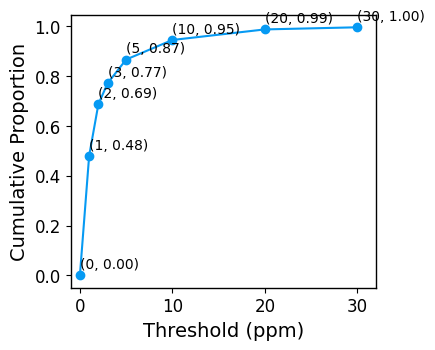


--------Validation results plot--------


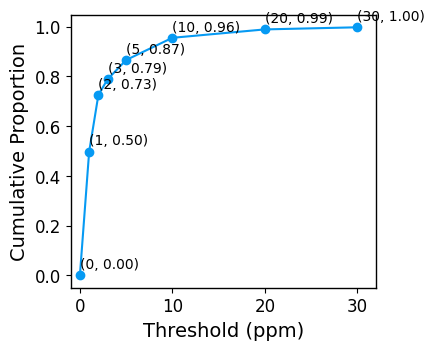


--------Training results scatter plot--------
R2 = 0.98
RMSE = 5.02
MAE = 2.559472468986814


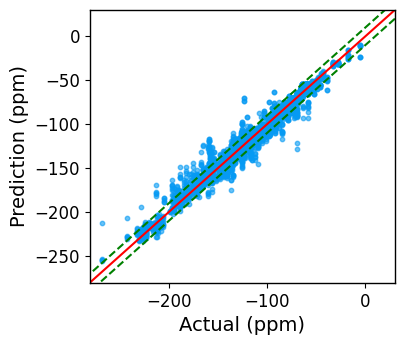


--------Validation results scatter plot--------
R2 = 0.97
RMSE = 4.74
MAE = 2.4140019565027346


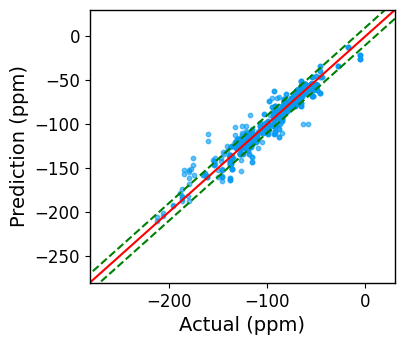

In [10]:
param_grid = {
            "max_depth": [2, 3, 4],  # deeper trees are more prone to overfitting.
            "learning_rate": [0.01, 0.05, 0.1],
            "n_estimators": [50, 100, 150],  # Corresponds to the number of boosting rounds
            "subsample": [0.7, 0.8, 0.9, 1.0],
            "gamma": [0.1, 0.2, 0.4],
            "reg_alpha": [0.1, 1, 2, 5, 10],
            "reg_lambda": [0.1, 1, 2, 5, 10],
        }

num_spheres = 3

# Use random seed 42 to find the best hyperparameters
_, _, _, _, best_params = train_and_validate_xgboost2d_model(num_spheres = num_spheres, train_dataset = train_dataset, param_grid = param_grid, random_seeds=[42], show_plot = False)

# Use the best hyperparameters to train and validate the model with multiple random seeds for seperating train and validation dataset
random_seeds = [42, 30, 512, 76, 61]
train_results_tables, train_results_df, vali_results_tables, vali_results_df, _ = train_and_validate_xgboost2d_model(
                                                                                            num_spheres = num_spheres, 
                                                                                            train_dataset = train_dataset, 
                                                                                            param_grid = best_params, 
                                                                                            random_seeds=random_seeds, 
                                                                                            show_plot = False, 
                                                                                            )

# Show the performance of the model on both training and validation datasets with the best hyperparameters and 5 random seeds
show_model_perfromance_on_both_train_and_vali(train_results_tables, train_results_df, vali_results_tables, vali_results_df, 
                                              model_info = f'XGBoost 2D neighbor atoms model with {len(train_results_df)} random seeds, num_spheres = {num_spheres}, best_params = {best_params}'
                                              )

## 3.4 Number of spheres: 4<a class="anchor" id="3.4"></a>


>>>>> Random seed: 42 <<<<<

param_grid: {'max_depth': [2, 3, 4], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [50, 100, 150], 'subsample': [0.7, 0.8, 0.9, 1.0], 'gamma': [0.1, 0.2, 0.4], 'reg_alpha': [0.1, 1, 2, 5, 10], 'reg_lambda': [0.1, 1, 2, 5, 10]}

Shape of dataset before preprocessing: (2215, 162)
Shape of dataset after preprocessing: (2215, 112)
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}
MAE Score: 3.19
Root Mean Squared Error (RMSE): 5.86
R^2 Score: 0.97
Save the model to ../artifacts/models/xgboost_model_2d_descriptors_sphere4.json successfully!
--------Training results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.451249,4.5092,0.982511


--------Validation results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.339727,5.034656,0.965603



>>>>> Random seed: 42 <<<<<

param_grid: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}

Shape of dataset before preprocessing: (2215, 162)
Shape of dataset after preprocessing: (2215, 112)
MAE Score: 3.19
Root Mean Squared Error (RMSE): 5.86
R^2 Score: 0.97
Save the model to ../artifacts/models/xgboost_model_2d_descriptors_sphere4.json successfully!

>>>>> Random seed: 30 <<<<<

param_grid: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}

Shape of dataset before preprocessing: (2257, 162)
Shape of dataset after preprocessing: (2257, 112)
MAE Score: 3.60
Root Mean Squared Error (RMSE): 7.18
R^2 Score: 0.95
Save the model to ../artifacts/models/xgboost_model_2d_descriptors_sphere4.json successfully!

>>>>> Random seed: 512 <<<<<

param_grid: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, '

,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.451249,4.509200,0.982511
"random_seed = 30, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.391678,4.720878,0.980468
"random_seed = 512, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.402882,4.718085,0.980929
"random_seed = 76, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.404933,4.947870,0.978305
"random_seed = 61, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.424557,5.065269,0.978533


--------Validation results DataFrame--------


,mae,rmse,r2
Parameters,,,
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.339727,5.034656,0.965603
"random_seed = 30, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.135336,3.798147,0.981702
"random_seed = 512, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.369520,4.770064,0.967888
"random_seed = 76, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.871829,5.170865,0.964759
"random_seed = 61, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.158796,4.550191,0.971046



>>>>> Model information: XGBoost 2D neighbor atoms model with 5 random seeds, num_spheres = 4, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2} <<<<<

Performance of the model on training dataset
mae: 2.42 ± 0.02
rmse: 4.79 ± 0.22
r2: 0.98 ± 0.00

Performance of model on validation dataset
mae: 2.38 ± 0.30
rmse: 4.66 ± 0.54
r2: 0.97 ± 0.01

--------Training results plot--------


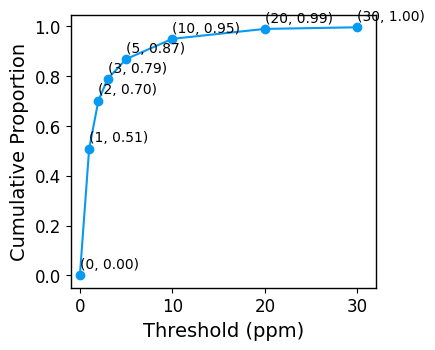


--------Validation results plot--------


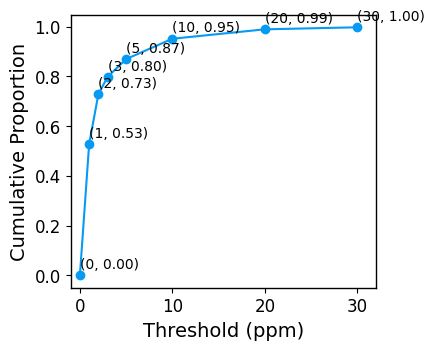


--------Training results scatter plot--------
R2 = 0.98
RMSE = 4.80
MAE = 2.4147638484280693


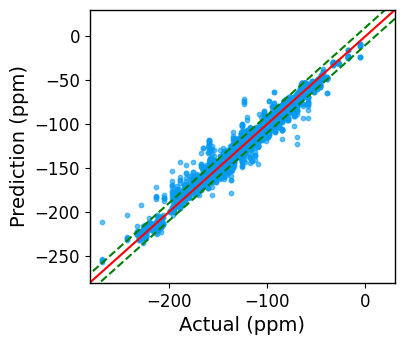


--------Validation results scatter plot--------
R2 = 0.97
RMSE = 4.68
MAE = 2.3568158927982483


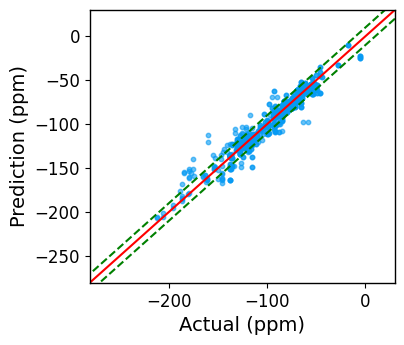

In [11]:
num_spheres = 4

# Use random seed 42 to find the best hyperparameters
_, _, _, _, best_params = train_and_validate_xgboost2d_model(num_spheres = num_spheres, train_dataset = train_dataset, param_grid = param_grid, random_seeds=[42], show_plot = False)

# Use the best hyperparameters to train and validate the model with multiple random seeds for seperating train and validation dataset
random_seeds = [42, 30, 512, 76, 61]
train_results_tables, train_results_df, vali_results_tables, vali_results_df, _ = train_and_validate_xgboost2d_model(
                                                                                            num_spheres = num_spheres, 
                                                                                            train_dataset = train_dataset, 
                                                                                            param_grid = best_params, 
                                                                                            random_seeds=random_seeds, 
                                                                                            show_plot = False, 
                                                                                            )

# Show the performance of the model on both training and validation datasets with the best hyperparameters and 5 random seeds
show_model_perfromance_on_both_train_and_vali(train_results_tables, train_results_df, vali_results_tables, vali_results_df, 
                                              model_info = f'XGBoost 2D neighbor atoms model with {len(train_results_df)} random seeds, num_spheres = {num_spheres}, best_params = {best_params}'
                                              )

## 3.5 Number of spheres: 5<a class="anchor" id="3.5"></a>


>>>>> Random seed: 42 <<<<<

param_grid: {'max_depth': [2, 3, 4], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [50, 100, 150], 'subsample': [0.7, 0.8, 0.9, 1.0], 'gamma': [0.1, 0.2, 0.4], 'reg_alpha': [0.1, 1, 2, 5, 10], 'reg_lambda': [0.1, 1, 2, 5, 10]}

Shape of dataset before preprocessing: (2215, 232)
Shape of dataset after preprocessing: (2215, 147)
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}
MAE Score: 3.38
Root Mean Squared Error (RMSE): 6.28
R^2 Score: 0.97
Save the model to ../artifacts/models/xgboost_model_2d_descriptors_sphere5.json successfully!
--------Training results DataFrame--------


,mae,rmse,r2
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.407812,4.449771,0.982969


--------Validation results DataFrame--------


,mae,rmse,r2
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.364162,5.009117,0.965951



>>>>> Random seed: 42 <<<<<

param_grid: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}

Shape of dataset before preprocessing: (2215, 232)
Shape of dataset after preprocessing: (2215, 147)
MAE Score: 3.38
Root Mean Squared Error (RMSE): 6.28
R^2 Score: 0.97
Save the model to ../artifacts/models/xgboost_model_2d_descriptors_sphere5.json successfully!

>>>>> Random seed: 30 <<<<<

param_grid: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}

Shape of dataset before preprocessing: (2257, 232)
Shape of dataset after preprocessing: (2257, 140)
MAE Score: 3.51
Root Mean Squared Error (RMSE): 7.15
R^2 Score: 0.96
Save the model to ../artifacts/models/xgboost_model_2d_descriptors_sphere5.json successfully!

>>>>> Random seed: 512 <<<<<

param_grid: {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, '

,mae,rmse,r2
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.407812,4.449771,0.982969
"random_seed = 30, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.252640,4.517194,0.982117
"random_seed = 512, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.378009,4.625716,0.981668
"random_seed = 76, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.375746,4.882952,0.978870
"random_seed = 61, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.359535,4.775635,0.980918


--------Validation results DataFrame--------


,mae,rmse,r2
"random_seed = 42, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.364162,5.009117,0.965951
"random_seed = 30, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.134025,3.859193,0.981109
"random_seed = 512, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.456205,4.633046,0.969706
"random_seed = 76, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.877942,5.293271,0.963071
"random_seed = 61, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2}",2.470391,5.392358,0.959337



>>>>> Model information: XGBoost 2D neighbor atoms model with 5 random seeds, num_spheres = 5, best_params = {'subsample': 0.9, 'reg_lambda': 2, 'reg_alpha': 10, 'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.2} <<<<<

Performance of the model on training dataset
mae: 2.35 ± 0.06
rmse: 4.65 ± 0.18
r2: 0.98 ± 0.00

Performance of model on validation dataset
mae: 2.46 ± 0.27
rmse: 4.84 ± 0.62
r2: 0.97 ± 0.01

--------Training results plot--------


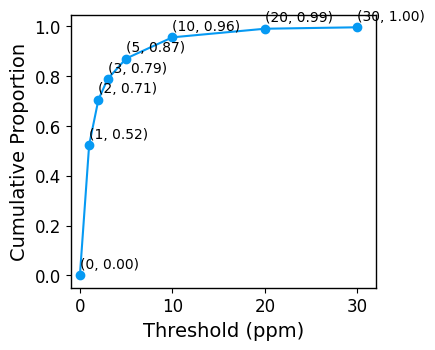


--------Validation results plot--------


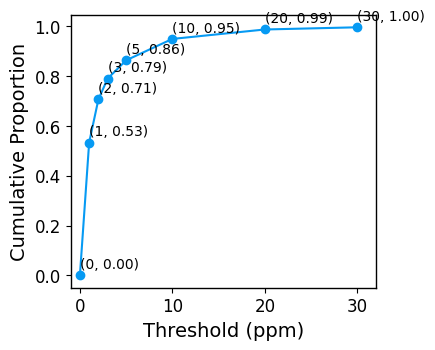


--------Training results scatter plot--------
R2 = 0.98
RMSE = 4.65
MAE = 2.354658237539886


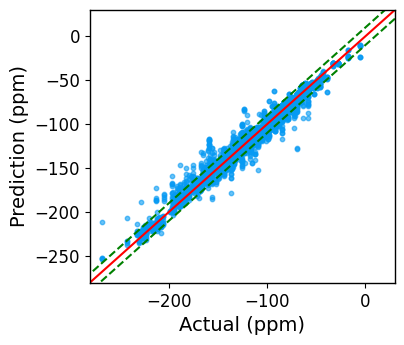


--------Validation results scatter plot--------
R2 = 0.97
RMSE = 4.88
MAE = 2.4505113098370837


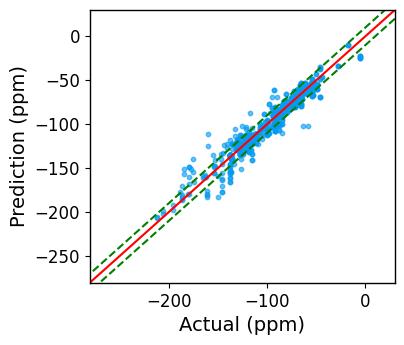

In [29]:
num_spheres = 5

# Use random seed 42 to find the best hyperparameters
_, _, _, _, best_params = train_and_validate_xgboost2d_model(num_spheres = num_spheres, train_dataset = train_dataset, param_grid = param_grid, random_seeds=[42], show_plot = False)

# Use the best hyperparameters to train and validate the model with multiple random seeds for seperating train and validation dataset
random_seeds = [42, 30, 512, 76, 61]
train_results_tables_s5, train_results_df, vali_results_tables_s5, vali_results_df, _ = train_and_validate_xgboost2d_model(
                                                                                            num_spheres = num_spheres, 
                                                                                            train_dataset = train_dataset, 
                                                                                            param_grid = best_params, 
                                                                                            random_seeds=random_seeds, 
                                                                                            show_plot = False, 
                                                                                            )

# Show the performance of the model on both training and validation datasets with the best hyperparameters and 5 random seeds
show_model_perfromance_on_both_train_and_vali(train_results_tables_s5, train_results_df, vali_results_tables_s5, vali_results_df, 
                                              model_info = f'XGBoost 2D neighbor atoms model with {len(train_results_df)} random seeds, num_spheres = {num_spheres}, best_params = {best_params}'
                                              )

train_results_tables_s5.to_csv(os.path.join("..", "artifacts", "results", "XGBoost 2D_s5_Results On Training Dataset with 5 Random Seeds.csv"), index=True)
vali_results_tables_s5.to_csv(os.path.join("..", "artifacts", "results", "XGBoost 2D_s5_Results On Validation Dataset with 5 Random Seeds.csv.csv"), index=True)

## 3.5 Save best model and its prediction performance on the validation dataset

In [46]:
# # Saving best results to a CSV file
# file_path = os.path.join(
#     "..", "artifacts", "results", "XGBoost_2DFeatureSet_validation_dataset_sphere4.csv"
# )
# results_table_sphere4.to_csv(file_path, encoding="UTF-8")

## 3.6 Feature Importance Analysis <a class="anchor" id="3.6"></a>
**Top 10 Important Features Evaluated Based on Information Gain**

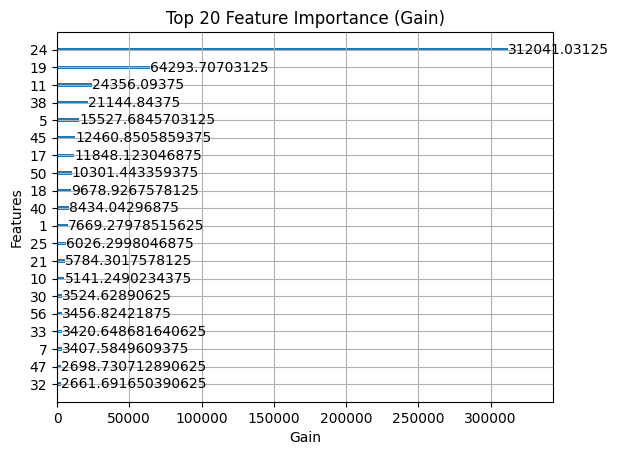

In [56]:
# best_model = XGBRegressor()
# file_path = os.path.join(
#     "..", "artifacts", "models", "xgboost_model_2d_descriptors_sphere4.json"
# )
# best_model.load_model(file_path)

# xgb.plot_importance(best_model, importance_type="gain", max_num_features=20)
# plt.title("Top 20 Feature Importance (Gain)")
# plt.xlabel("Gain")
# plt.ylabel("Features")
# plt.show()

In [57]:
# feature_ids = [24, 19, 11, 38, 5, 45, 17, 50, 18, 40, 1, 25, 21, 10, 30, 56, 33, 7, 47, 32]
# # feature_ids = [0, 1, 2, 3, 4, 5, 6]
# for feature_id in feature_ids:
#     print(common.get_readable_feature_name_2d(feature_id))

The feature_id '24' corresponds to the 'degree' of the atom in Sphere '2', Item '3'
The feature_id '19' corresponds to the 'explicit_valence' of the atom in Sphere '2', Item '2'
The feature_id '11' corresponds to the 'valence' of the atom in Sphere '2', Item '1'
The feature_id '38' corresponds to the 'degree' of the atom in Sphere '3', Item '2'
The feature_id '5' corresponds to the 'explicit_valence' of the atom in Sphere '1', Item '1'
The feature_id '45' corresponds to the 'degree' of the atom in Sphere '3', Item '3'
The feature_id '17' corresponds to the 'degree' of the atom in Sphere '2', Item '2'
The feature_id '50' corresponds to the 'hybridization' of the atom in Sphere '3', Item '4'
The feature_id '18' corresponds to the 'valence' of the atom in Sphere '2', Item '2'
The feature_id '40' corresponds to the 'explicit_valence' of the atom in Sphere '3', Item '2'
The feature_id '1' corresponds to the 'hybridization' of the atom in Sphere '1', Item '1'
The feature_id '25' corresponds 

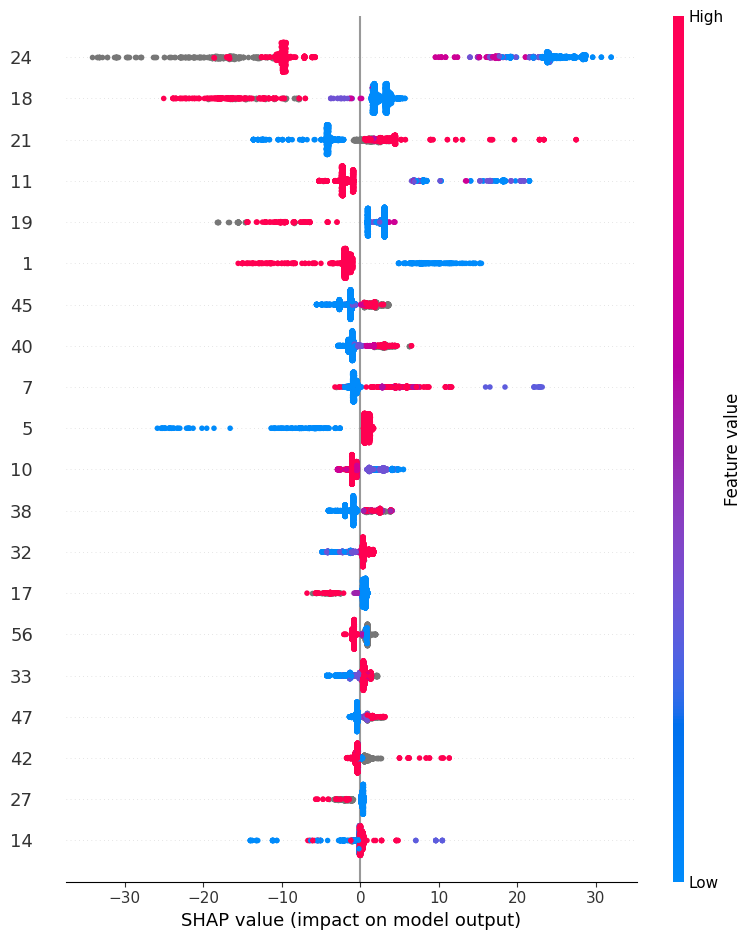

In [58]:
# get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
# train_content = get_2d_descriptors.getDescriptorsFromDataset(
#     train_fluorinated_compounds, 4
# )

# train_content = train_content.dropna(subset=["NMR_Peaks"])
# y_train = train_content["NMR_Peaks"]
# X_train = train_content.drop(["NMR_Peaks"], axis=1)

# # Create the SHAP explainer
# explainer = shap.TreeExplainer(best_model)
# shap_values = explainer.shap_values(X_train)

# # Plot the summary plot
# shap.summary_plot(shap_values, X_train)

**Why feature 24 is most important**

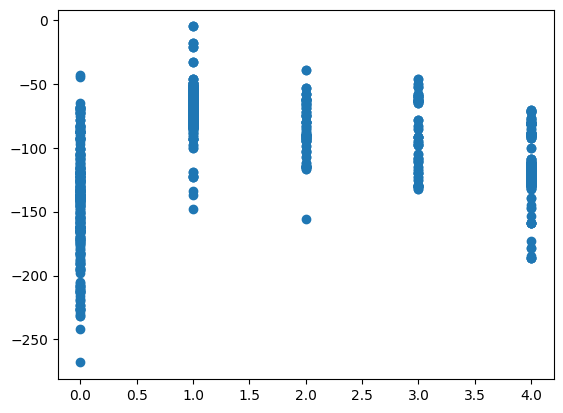

In [59]:
# feature_id = 24  # Revise this value to see the relationship between NMR shifts and different features
# rel_24_shifts = train_content.loc[:, [feature_id, "NMR_Peaks"]]
# rel_24_shifts[feature_id].fillna(0, inplace=True)
# plt.plot(rel_24_shifts[feature_id], rel_24_shifts["NMR_Peaks"], "o")


**I use 0 to replace NaN values in the column '24'**  

'24' == NaN basically means that the target atom does not have a neighbor atom at sphere 2 position 3. This is a valid scenario in the dataset. 

In [60]:
train_content.NMR_Peaks = train_content.NMR_Peaks.apply(common.convert_to_numeric)
selected_shifts = train_content[train_content[24] == 4.0]['NMR_Peaks']

print('--------24: 4.0--------')
selected_shifts.mean
print(f'mean: {selected_shifts.mean()}')
print(f'std: {selected_shifts.std()}')
print(f'min: {selected_shifts.min()}')
print(f'max: {selected_shifts.max()}')
print(f'count: {selected_shifts.count()}')

selected_shifts = train_content[train_content[24] == 3.0]['NMR_Peaks']
print('--------24: 3.0--------')
print(f'mean: {selected_shifts.mean()}')
print(f'std: {selected_shifts.std()}')
print(f'min: {selected_shifts.min()}')
print(f'max: {selected_shifts.max()}')
print(f'count: {selected_shifts.count()}')

selected_shifts = train_content[train_content[24] == 2.0]['NMR_Peaks']
print('--------24: 2.0--------')
print(f'mean: {selected_shifts.mean()}')
print(f'std: {selected_shifts.std()}')
print(f'min: {selected_shifts.min()}')
print(f'max: {selected_shifts.max()}')
print(f'count: {selected_shifts.count()}')

selected_shifts = train_content[train_content[24] == 1.0]['NMR_Peaks']
print('--------24: 1.0--------')
print(f'mean: {selected_shifts.mean()}')
print(f'std: {selected_shifts.std()}')
print(f'min: {selected_shifts.min()}')
print(f'max: {selected_shifts.max()}')
print(f'count: {selected_shifts.count()}')

selected_shifts = train_content[train_content[24].isna()]['NMR_Peaks']
print('--------24: NaN--------')
print(f'mean: {selected_shifts.mean()}')
print(f'std: {selected_shifts.std()}')
print(f'min: {selected_shifts.min()}')
print(f'max: {selected_shifts.max()}')
print(f'count: {selected_shifts.count()}')

--------24: 4.0--------
mean: -119.77089349112427
std: 13.315219743580618
min: -186.25
max: -70.4
count: 1014
--------24: 3.0--------
mean: -89.93662921348316
std: 27.724903391249843
min: -132.0
max: -46.0
count: 89
--------24: 2.0--------
mean: -84.97360824742266
std: 20.482854628198954
min: -156.0
max: -39.0
count: 97
--------24: 1.0--------
mean: -72.03302521008403
std: 14.156567859342385
min: -148.0
max: -5.1
count: 714
--------24: NaN--------
mean: -141.22627071823206
std: 39.735247073790184
min: -268.0
max: -43.0
count: 362


In [61]:
selected_shifts = train_content[(train_content[24] == 1) & (train_content['NMR_Peaks'] < -86)]
selected_shifts

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,NMR_Peaks
7_From_Review_240,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,2.0,4.0,2.0,0.0,12.011,3.0,0.0,1.0,4.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,2.0,4.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-93.00
8_From_Review_240,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,2.0,4.0,2.0,0.0,12.011,3.0,0.0,1.0,4.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,2.0,4.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-93.00
5_From_Review_285,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-88.20
6_From_Review_285,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-88.20
7_From_Review_285,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-88.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19_COOH_11,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,...,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-119.24
20_COOH_11,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,...,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-119.24
6_From_Review_81,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,2.0,4.0,2.0,0.0,12.011,3.0,0.0,1.0,4.0,1.0,0.0,12.011,3.0,0.0,

In [62]:
selected_shifts.index

Index(['7_From_Review_240', '8_From_Review_240', '5_From_Review_285',
       '6_From_Review_285', '7_From_Review_285', '9_From_Review_244',
       '10_From_Review_244', '6_From_Review_239', '7_From_Review_239',
       '8_From_Review_95', '7_From_Review_85', '5_From_Review_226',
       '6_From_Review_226', '4_From_Review_203', '5_From_Review_203',
       '11_COOH_11', '13_COOH_11', '14_COOH_11', '16_COOH_11', '17_COOH_11',
       '19_COOH_11', '20_COOH_11', '6_From_Review_81', '7_From_Review_249',
       '8_From_Review_249'],
      dtype='object')

In [63]:
from IPython.display import Image

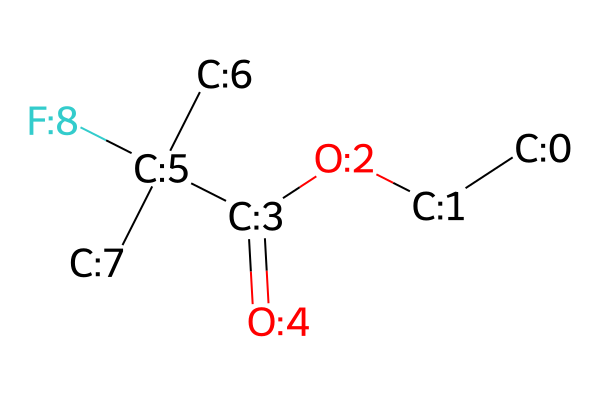

In [64]:
temp = 'From_Review_95'
file_path = os.path.join("..", "dataset", "pictures", f"{temp}.png")
if os.path.exists(file_path):
    display(Image(file_path))

In [65]:
# [24] = 4, a saturated C atom, usually near the end CF3 group.
# [24] = 3, near a C atom in benzene ring, or CF2 group, COOH group.
# [24] = 2, near ether O, CH2 group,  C atom in double bond but not in bezene ring.
# [24] = 1, mostly in CF3 group, some in CF2Cl, 

# Therefore, the model identified the surrounding atoms of the target atom and their types, and their bounding type to the target atom, are important features to predict the NMR shifts of the target atom.
# Feature 24 carries a lot of information.


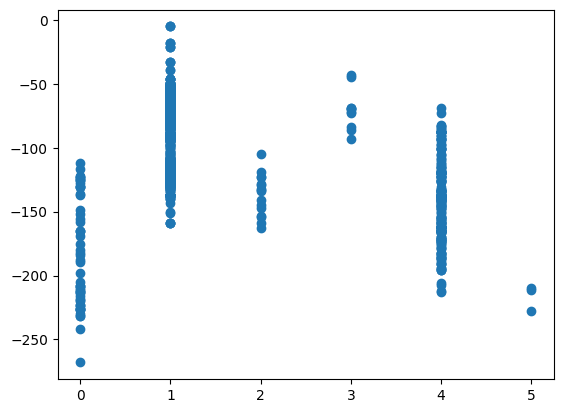

In [66]:
feature_id = 18  # Revise this value to see the relationship between NMR shifts and different features
rel_18_shifts = train_content.loc[:, [feature_id, "NMR_Peaks"]]
rel_18_shifts[feature_id].fillna(0, inplace=True)
plt.plot(rel_18_shifts[feature_id], rel_18_shifts["NMR_Peaks"], "o")

** I replace NaN values in feture '18' by 0 to plot the above graph. **

In [67]:
selected_shifts = train_content[train_content[18] == 1.0]['NMR_Peaks']
print('--------18: 1.0--------')
selected_shifts.mean
print(f'mean: {selected_shifts.mean()}')
print(f'std: {selected_shifts.std()}')
print(f'min: {selected_shifts.min()}')
print(f'max: {selected_shifts.max()}')
print(f'count: {selected_shifts.count()}')

selected_shifts = train_content[train_content[18] == 2.0]['NMR_Peaks']
print('--------18: 2.0--------')
print(f'mean: {selected_shifts.mean()}')
print(f'std: {selected_shifts.std()}')
print(f'min: {selected_shifts.min()}')
print(f'max: {selected_shifts.max()}')
print(f'count: {selected_shifts.count()}')

selected_shifts = train_content[train_content[18] == 3.0]['NMR_Peaks']
print('--------18: 3.0--------')
print(f'mean: {selected_shifts.mean()}')
print(f'std: {selected_shifts.std()}')
print(f'min: {selected_shifts.min()}')
print(f'max: {selected_shifts.max()}')
print(f'count: {selected_shifts.count()}')

selected_shifts = train_content[train_content[18] == 4.0]['NMR_Peaks']
print('--------18: 4.0--------')
print(f'mean: {selected_shifts.mean()}')
print(f'std: {selected_shifts.std()}')
print(f'min: {selected_shifts.min()}')
print(f'max: {selected_shifts.max()}')
print(f'count: {selected_shifts.count()}')

selected_shifts = train_content[train_content[18] == 5.0]['NMR_Peaks']
print('--------18: 5.0--------')
print(f'mean: {selected_shifts.mean()}')
print(f'std: {selected_shifts.std()}')
print(f'min: {selected_shifts.min()}')
print(f'max: {selected_shifts.max()}')
print(f'count: {selected_shifts.count()}')




--------18: 1.0--------
mean: -98.77243010752689
std: 26.714559979626777
min: -159.0
max: -5.1
count: 1953
--------18: 2.0--------
mean: -136.79375
std: 15.931539735171027
min: -163.0
max: -105.0
count: 16
--------18: 3.0--------
mean: -70.36363636363636
std: 15.324964778248122
min: -93.0
max: -43.0
count: 11
--------18: 4.0--------
mean: -141.10987234042554
std: 31.70991880844753
min: -213.0
max: -69.0
count: 235
--------18: 5.0--------
mean: -216.33333333333334
std: 10.115993936995679
min: -228.0
max: -210.0
count: 3


In [68]:
selected_shifts = train_content[(train_content[18] == 4)]
selected_shifts.tail(20)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,NMR_Peaks
14_COOH_11,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,...,15.999,2.0,0.0,1.0,2.0,2.0,0.0,15.999,2.0,0.0,1.0,2.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-123.11
16_COOH_11,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,...,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-121.93
17_COOH_11,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,...,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-121.93
19_COOH_11,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,...,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-119.24
20_COOH_11,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,...,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-119.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7_From_Review_457,12.011,2.0,1.0,3.0,4.0,4.0,1.0,12.011,2.0,1.0,3.0,4.0,4.0,1.0,12.011,2.0,1.0,3.0,4.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.011,2.0,1.0,3.0,4.0,4.0,1.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,...,12.011,2.0,1.0,3.0,4.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-171.20
9_From_Review_457,12.011,2.0,1.0,3.0,4.0,4.0,1.0,12.011,2.0,1.0,3.0,4.0,4.0,1.0,12.011,2.0,1.0,3.0,4.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.011,2.0,1.0,3.0,4.0,4.0,1.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,...,12.011,2.0,1.0,3.0,4.0,4.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-165.80
11_From_Review_457,12.011,2.0,1.0,3.0,4.0,4.0,1.0,12.011,2.0,1.0,3.0,4.0,4.0,1.0,12.011,2.

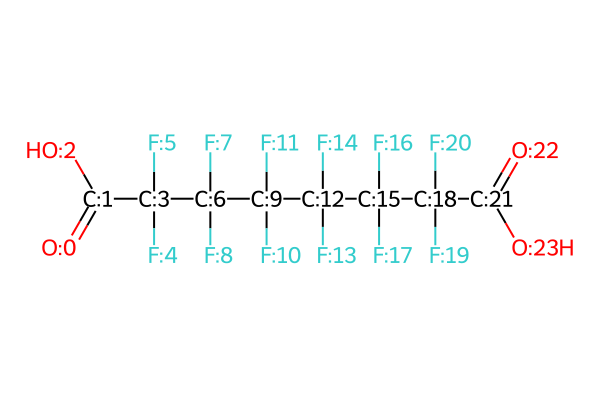

In [69]:
temp = 'COOH_11'
file_path = os.path.join("..", "dataset", "pictures", f"{temp}.png")
if os.path.exists(file_path):
    display(Image(file_path))

In [70]:
X_content_PFOA = train_content[train_content.index.str.contains("COOH_6")]
X_content_PFOA

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,NMR_Peaks
4_COOH_6,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,15.999,2.0,0.0,1.0,2.0,2.0,0.0,15.999,2.0,0.0,1.0,2.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-119.16
5_COOH_6,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,15.999,2.0,0.0,1.0,2.0,2.0,0.0,15.999,2.0,0.0,1.0,2.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-119.16
7_COOH_6,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,...,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-121.84
8_COOH_6,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,2.0,0.0,3.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,...,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-121.84
10_COOH_6,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,...,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-122.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19_COOH_6,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-126.27
20_COOH_6,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-126.27
22_COOH_6,12.011,3.0,0.0,4.0,4.0,4.0,0.0,12.011,3.0,0.0,4.0,4.0,4.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,0.0,18.998,3.0,0.0,1.0,1.0,1.0,

In [71]:
shap_values_with_index_col = pd.DataFrame(shap_values)
shap_values_with_index_col.columns = X_train.columns
shap_values_with_index_col.index = X_train.index

# PFOA = 'COOH_6'
shap_values_PFOA = shap_values_with_index_col[
    shap_values_with_index_col.index.str.contains("COOH_6")
]
shap_values_PFOA

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160
4_COOH_6,0.0,-1.855622,-0.012391,0.009075,0.0,1.012384,0.175828,-0.926199,0.111755,0.005782,-1.049012,-2.258172,0.001432,0.024623,0.007537,0.038717,0.071491,0.771499,3.855027,3.062154,0.0,-4.311715,-0.002867,0.0,-9.733726,-0.086020,0.021488,0.419330,-0.332054,0.043198,-0.082806,-0.009071,-1.069864,-0.084258,-0.057543,-0.025410,0.337990,-0.028165,-0.781078,0.0,-0.866425,0.0,-0.523050,0.0,0.0,-1.097373,0.0,-0.344196,0.0,-0.102611,...,0.108083,-0.107759,-0.013320,-0.154643,-0.050811,0.0,-0.015302,0.0,0.0,0.0,0.0,-0.005332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5_COOH_6,0.0,-1.855622,-0.012391,0.009075,0.0,1.012384,0.175828,-0.926199,0.111755,0.005782,-1.049012,-2.258172,0.001432,0.024623,0.007537,0.038717,0.071491,0.771499,3.855027,3.062154,0.0,-4.311715,-0.002867,0.0,-9.733726,-0.086020,0.021488,0.419330,-0.332054,0.043198,-0.082806,-0.009071,-1.069864,-0.084258,-0.057543,-0.025410,0.337990,-0.028165,-0.781078,0.0,-0.866425,0.0,-0.523050,0.0,0.0,-1.097373,0.0,-0.344196,0.0,-0.102611,...,0.108083,-0.107759,-0.013320,-0.154643,-0.050811,0.0,-0.015302,0.0,0.0,0.0,0.0,-0.005332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7_COOH_6,0.0,-2.014442,-0.012166,0.008310,0.0,0.997417,0.181083,-0.861392,-0.037016,0.005671,-1.075089,-2.282011,0.008571,0.003539,-0.080879,0.029064,-0.027986,0.645578,3.158922,3.022663,0.0,-4.139939,-0.002867,0.0,-10.093122,-0.083538,0.021488,0.304507,0.067513,-0.037339,-0.123990,0.002257,0.287831,0.269792,-0.013422,-0.140506,-0.137078,-0.075397,-0.914427,0.0,-1.021922,0.0,-0.384297,0.0,0.0,-1.227710,0.0,-0.443531,0.0,-0.348713,...,0.118497,0.301120,0.047525,0.131547,0.274452,0.0,-0.009936,0.0,0.0,0.0,0.0,0.373018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8_COOH_6,0.0,-2.014442,-0.012166,0.008310,0.0,0.997417,0.181083,-0.861392,-0.037016,0.005671,-1.075089,-2.282011,0.008571,0.003539,-0.080879,0.029064,-0.027986,0.645578,3.158922,3.022663,0.0,-4.139939,-0.002867,0.0,-10.093122,-0.083538,0.021488,0.304507,0.067513,-0.037339,-0.123990,0.002257,0.287831,0.269792,-0.013422,-0.140506,-0.137078,-0.075397,-0.914427,0.0,-1.021922,0.0,-0.384297,0.0,0.0,-1.227710,0.0,-0.443531,0.0,-0.348713,...,0.118497,0.301120,0.047525,0.131547,0.274452,0.0,-0.009936,0.0,0.0,0.0,0.0,0.373018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10_COOH_6,0.0,-1.896762,-0.012166,0.008311,0.0,1.085301,0.179901,-0.872547,-0.037016,0.009860,-1.076806,-2.266810,0.008571,0.003539,-0.094468,0.029064,-0.029163,0.645578,3.339702,3.069830,0.0,-4.230144,-0.002867,0.0,-9.866159,-0.093250,0.021488,0.338551,0.067164,-0.077269,-0.123990,0.006014,0.318033,0.370259,-0.013422,-0.140280,-0.137078,-0.092756,-0.911546,0.0,-1.039978,0.0,-0.385104,0.0,0.0,-1.270809,0.0,-0.443531,0.0,-0.097812,...,0.118497,0.286841,0.047525,0.131547,0.232478,0.0,-0.015302,0.0,0.0,0.0,0.0,-0.031880,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.016258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [72]:
pd.set_option("display.max_rows", 100)
# pd.set_option("display.max_columns", 100)
shap_values_PFOA.abs().mean().sort_values(ascending=False)[:20]

24    12.669160
21     4.270940
18     3.109983
19     2.645725
11     1.997562
1      1.752242
45     1.523342
40     1.110862
38     1.102312
10     0.960409
5      0.951850
56     0.843312
7      0.808481
17     0.593448
50     0.586842
42     0.452975
32     0.433835
47     0.429048
33     0.362250
27     0.319660
dtype: float32

## 4.3 Evaluate the Performance of the Models Using the Test Dataset<a class="anchor" id="4.3"></a>

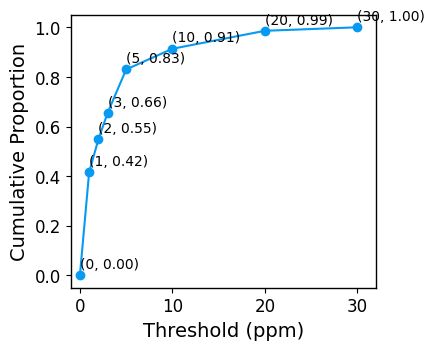

R2 = 0.96
RMSE = 5.69
MAE = 3.276282499538632


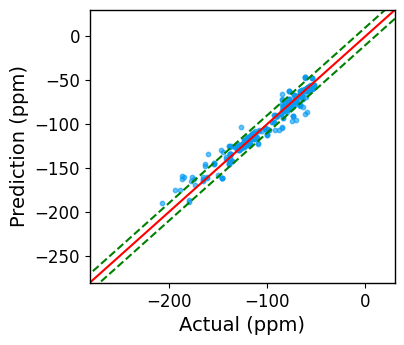

In [ ]:
# Comparision of best performing models using the test dataset
# xgboost, 3D atomic features with 5 neighbor atoms
base_file_path = os.path.join("..", "artifacts", "models")

results_table_test_neighbor_5 = (
    atomic_features_3D.testModelPerformance_XGBoost_3DNeighborAtoms(
        best_model_file_path=os.path.join(
            base_file_path, "xgboost_model_neighbor5.json"
        ),
        columns_file_path=os.path.join(
            base_file_path, "column_names_neighbor5_xgboost.pkl"
        ),
        num_neighbor=5,
        test_dataset=test_fluorinated_compounds,
    )
)

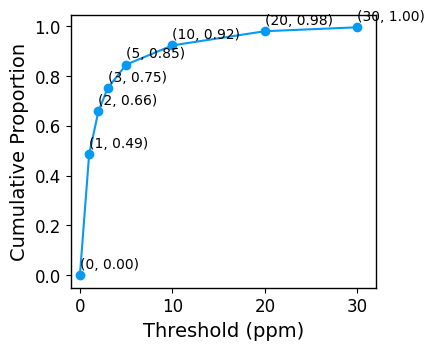

R2 = 0.96
RMSE = 5.87
MAE = 3.004745899044001


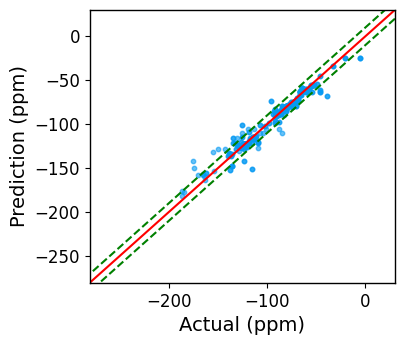

In [48]:
# Test model performance on the test dataset, 2D atomic features with 4 spheres
get_2d_descriptors = atomic_features_2D.getAtomicDescriptorsFrom2DNeighbors()
file_path = os.path.join(
    "..", "artifacts", "models", "xgboost_model_2d_descriptors_sphere4.json"
)
results_table_sphere3 = get_2d_descriptors.testXGBoost2DModelPerformance(
    file_path, vali_fluorinated_compounds, 4
)

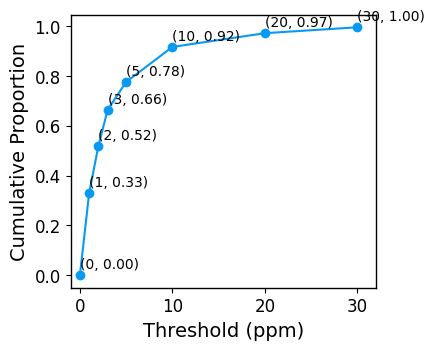

R2 = 0.94
RMSE = 7.44
MAE = 3.876242649560922


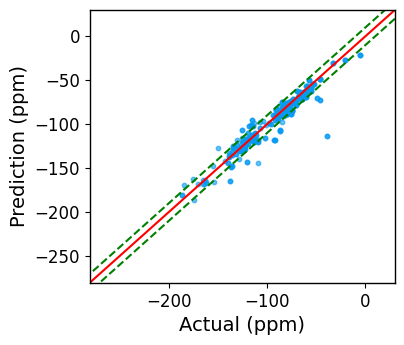

In [49]:
# Ridge model with 2D feature set, spheres = 4

base_file_path = os.path.join("..", "artifacts", "models")
restuls_table = atomic_features_2D.testRidgePerformance2DFeatures(
    dataset=vali_fluorinated_compounds,
    num_spheres=4,
    RidgeCVmodel_path=os.path.join(base_file_path, "RidgeCV_model_2d_sphere4.pkl"),
    scaler_path=os.path.join(base_file_path, "scaler_2d_sphere4_Ridge.pkl"),
    imputer_path=os.path.join(base_file_path, "imputer_2d_sphere4_Ridge.pkl"),
    columns_path=os.path.join(base_file_path, "column_names_2d_sphere4_Ridge.pkl"),
)

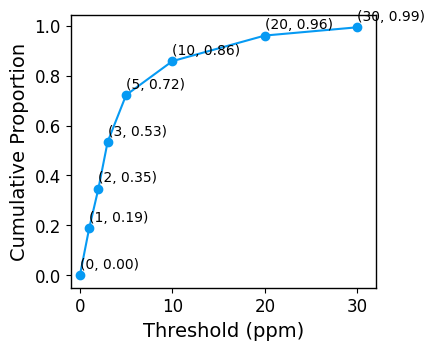

R2 = 0.93
RMSE = 7.70
MAE = 4.874815449741534


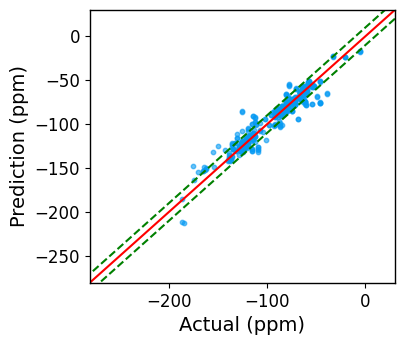

,actual,prediction,diff
3_ethers_9,-125.54,-85.296843,40.243157
4_ethers_9,-125.54,-86.567393,38.972607
6_ethers_9,-140.01,-140.662640,0.652640
7_ethers_9,-140.01,-141.130956,1.120956
12_From_Review_301,-74.00,-74.829151,0.829151
...,...,...,...
12_ether_21,-88.34,-89.674590,1.334590
13_ether_21,-88.34,-91.471580,3.131580
15_ether_21,-83.72,-87.218217,3.498217
16_ether_21,-83.72,-85.830393,2.110393


In [ ]:
# Ridge model with 3D feature set, neighboring atoms = 5
base_file_path = os.path.join("..", "artifacts", "models")
common.testRidgeCVPerformance(
    dataset=vali_fluorinated_compounds,
    num_neighbor=5,
    RidgeCVmodel_path=os.path.join(base_file_path, "RidgeCV_model_neighbor3.pkl"),
    scaler_path=os.path.join(base_file_path, "scaler_3d_neighbor3_RidgeCV.pkl"),
    imputer_path=os.path.join(base_file_path, "imputer_neighbor3_RidgeCV.pkl"),
    columns_path=os.path.join(base_file_path, "column_names_neighbor3_RidgeCV.pkl"),
)

The XGBoost model with 3D feature set with 5 neighboring atoms performes best. 